In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

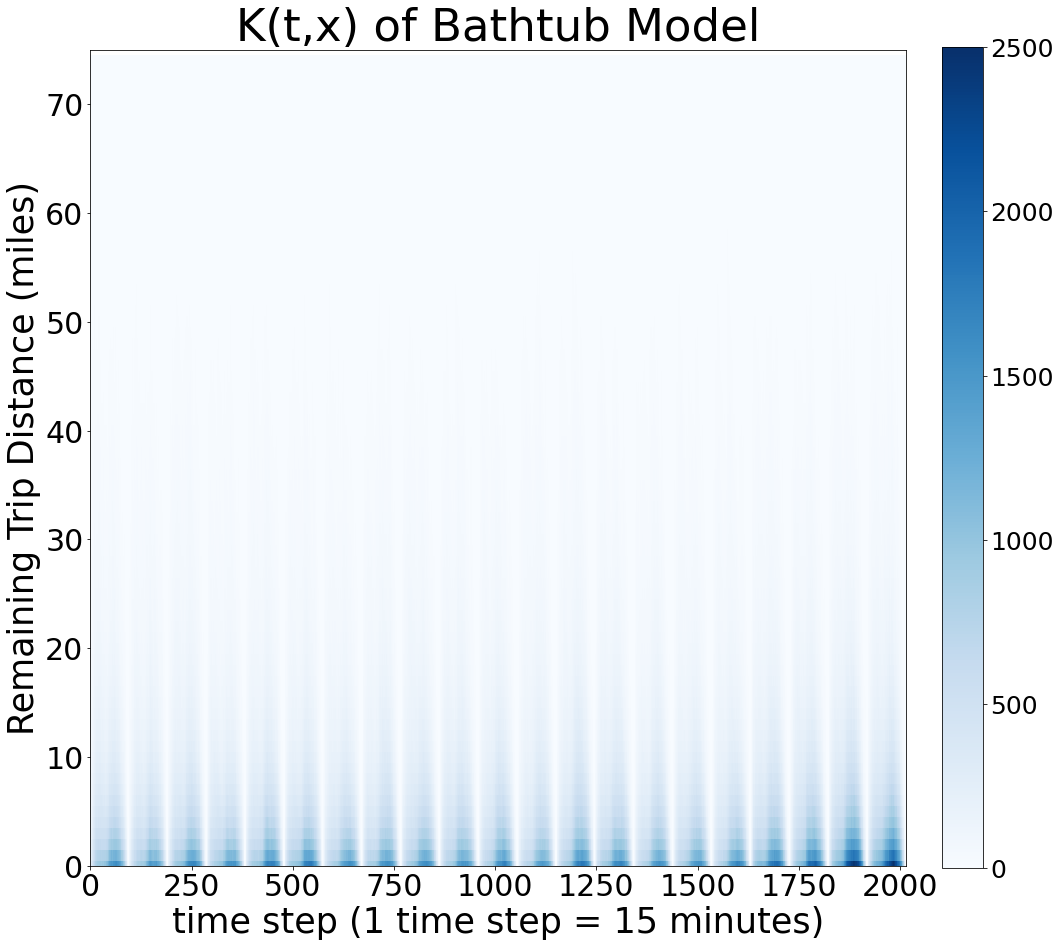

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,10,10,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.016644651922122861 0.027724801354333035 0.0055645024899126832 1.2657918911573371
0.0079559127289947577 0.01346615972462873 0.0024456657333607849 0.8910081880055007
0.0072283141259767616 0.012786507842584963 0.0016701204093685596 0.8682934554933542
0.0068971813540663948 0.012257437714547657 0.001536924993585132 0.8502451048348681
0.0057867451450765049 0.010171394468632734 0.0014020958215202768 0.7739130807115607
0.0053213652003889778 0.0094688936194040063 0.0011738367813739486 0.7449421652171809
0.0052697431371545858 0.0094131210218824542 0.001126365252426718 0.7426610137480659
0.00524843715091944 0.0094084582828568124 0.0010884160189820681 0.7425710769475717
0.0052099302577301989 0.00941642818636921 0.0010034323290911882 0.7430942123312436
0.0051344662999797874 0.0094394089598333081 0.00082952364012626621 0.7443851405021474
0.0050219590557134576 0.0094400789358687134 0.00060383917555820112 0.7449042909355296
0.0048679721915991332 0.0093222363385884969 0.00041370804460976921 0.7403508

0.0032340641929742551 0.0055246874908563108 0.0009434408950921994 0.5753732945652087
0.0032331061868342867 0.0055495641249264371 0.00091664824874213621 0.5765309766753164
0.0032312497332558157 0.0055349620191957978 0.00092753744731583388 0.5758191896094325
0.0032298253380360093 0.0055498514700441258 0.00090979920602789243 0.5765933572024685
0.00322962669713081 0.0055465727604695854 0.00091268063379203472 0.5763882660880858
0.0032292034030651407 0.0055485464324927314 0.00090986037363755 0.5764684582874251
0.0032288758962850639 0.0055525577730403241 0.00090519401952980345 0.5766703422843956
0.0032283755139509052 0.0055488672197917012 0.00090788380811010884 0.5764916096071117
0.0032280006458596548 0.0055422034407470976 0.00091379785097221245 0.5761121455147837
0.0032270996965437873 0.0055463734127574 0.00090782598033017458 0.5764023077295722
0.0032268045705395538 0.00553877691206951 0.00091483222900959739 0.5760090563375864
0.0032265838578921769 0.0055395662181713075 0.0009136014976130464

0.0032129563210058451 0.0055231032636376522 0.000902809378374038 0.5750630358552729
0.003212921845055069 0.0055245855452719156 0.00090125814483822263 0.5751222588474553
0.0032128892719341458 0.0055250587647170521 0.00090071977915123986 0.5751500251873055
0.0032128709202646683 0.0055253564713088473 0.00090038536922048954 0.5751620885772628
0.0032128588454157924 0.00552602499953028 0.00089969269130130483 0.5751892411456002
0.0032128378256792637 0.0055268408051791463 0.00089883484617938106 0.575225585886705
0.0032128141269342162 0.0055271412019753923 0.00089848705189304043 0.5752386936457438
0.00321278048947329 0.00552679949385247 0.00089876148509411037 0.5752163268021798
0.0032127183676211859 0.005527909543985964 0.000897527191256408 0.5752672685608574
0.0032126181682486433 0.0055286336296712767 0.00089660270682601 0.5752846978340467
0.0032125052515890873 0.0055241409764893524 0.00090086952668882233 0.5750456506633926
0.0032121782383219342 0.005539336893716244 0.00088501958292762481 0.57

0.0031912119546954184 0.00548024568441891 0.00090217822497192619 0.572424292366261
0.0031909854557108652 0.0054782049840821738 0.000903765927339557 0.5723278235675243
0.0031908981389356869 0.0054796679713525077 0.00090212830651886626 0.5724021596756503
0.0031908194332356272 0.0054793015478238312 0.00090233731864742292 0.5723977581321898
0.0031907515301810552 0.005478659688166969 0.0009028433721951411 0.572365508754511
0.003190658178018516 0.0054790250475821537 0.00090229130845487855 0.5723797110486493
0.0031905715114809497 0.0054791437073461232 0.00090199931561577647 0.5723868758859758
0.0031903117932530049 0.0054780980805813452 0.00090252550592466463 0.5723150399514343
0.0031900928948837477 0.0054796314834917046 0.00090055430627579078 0.5723897194378088
0.0031900183778708112 0.0054789182021066961 0.00090111855363492622 0.572343692573283
0.0031899458027853469 0.0054740786588439389 0.00090581294672675481 0.5720778451968267
0.0031899109634590042 0.0054749037865847909 0.000904918140333217

0.0031819387384096967 0.0054725254414077279 0.00089135203541166534 0.5718519401684682
0.0031818069054618233 0.0054708941312005908 0.00089271967972305544 0.5717889649244631
0.0031814805951717339 0.005469477633251103 0.00089348355709236522 0.571702660956555
0.0031812004565656984 0.0054679227033927764 0.00089447820973862023 0.5715862471397215
0.0031808349308662725 0.0054602902655368742 0.00090137959619567129 0.5711538602243879
0.0031804885303999362 0.0054659499969832819 0.00089502706381659042 0.57144925546731
0.0031803178111431641 0.0054640491201773441 0.00089658650210898449 0.5713479725215079
0.0031802058225649803 0.005463075187105244 0.00089733645802471656 0.5713140339004532
0.0031800994837849236 0.0054560720245787177 0.00090412694299112984 0.5709691453499531
0.0031798222895248977 0.0054524309798689718 0.000907213599180823 0.5707471061394327
0.0031796262795075951 0.0054549697328590109 0.00090428282615617945 0.5708958638917644
0.00317949937529669 0.0054559814777303357 0.00090301727286304

0.0031739331172153775 0.0054400793856154662 0.00090778684881528862 0.5700532525978361
0.0031739257451065348 0.0054382121942621563 0.00090963929595091325 0.5699685338019381
0.0031738967978957333 0.0054395276057411183 0.00090826599005034846 0.570042965581447
0.0031738632937154407 0.0054396588950158826 0.00090806769241499863 0.5700399967868078
0.0031737893875568093 0.0054398718985251117 0.00090770687658850739 0.5700467287895803
0.0031736928588370584 0.005442162575795894 0.000905223141878223 0.5701688214741729
0.0031736045620771865 0.0054442228232625513 0.00090298630089182149 0.5702616068673512
0.0031734718258230659 0.0054454307935943806 0.00090151285805175176 0.5703253411329294
0.0031733505138530323 0.0054423361945175747 0.00090436483318849037 0.5701464433478827
0.0031731485049959025 0.0054388854399025563 0.00090741157008924838 0.5699977808714561
0.0031730647444414709 0.005440917386846998 0.0009052121020359439 0.5701079771912517
0.0031730208234206567 0.0054369488101562663 0.00090909283668

0.003167683777583398 0.0054340274726705383 0.00090134008249625726 0.5696878237997206
0.0031675730758591435 0.0054319522224254482 0.00090319392929283935 0.5695968847413445
0.0031675149132175603 0.0054317396870885125 0.000903290139346608 0.5695729305565335
0.0031674508757168957 0.0054332671738953038 0.00090163457753848731 0.5696360849763811
0.0031674126204581095 0.0054346929417616579 0.000900132299154561 0.5697134423625234
0.0031673846020029862 0.005434907493636368 0.00089986171036960392 0.5697270533354595
0.0031673082459868361 0.005433953728852403 0.00090066276312126907 0.5696868567606957
0.0031672365219457834 0.00543473190816424 0.00089974113572732675 0.5697393948465629
0.0031671483244173322 0.0054352839428556989 0.00089901270597896542 0.5697795502892903
0.0031670493174714674 0.0054392077411181327 0.0008948908938248019 0.5699818526053404
0.0031669659215577827 0.0054399276382396727 0.00089400420487589229 0.5700160128368142
0.0031668504551254167 0.0054383521390025061 0.000895348771248327

0.0031558365189985962 0.0054083183895147621 0.00090335464848243007 0.5680457139114553
0.003155680901316136 0.0054089546424936959 0.00090240716013857572 0.5680673138075925
0.003155574940309817 0.0054073204697078292 0.00090382941091180467 0.5679794244923413
0.0031553950174652147 0.0054036889307833569 0.00090710110414707237 0.5677979637854697
0.0031551641286033417 0.0054045035120514635 0.00090582474515521992 0.5678500183709569
0.0031550844671058768 0.0054063368742782196 0.00090383205993353386 0.5679452982238948
0.0031548979847177655 0.0054106523929724 0.0008991435764631315 0.5681883782308436
0.003154830606468925 0.0054127695693944548 0.00089689164354339547 0.5682708720136296
0.0031546274793856203 0.0054045684422147425 0.00090468651655649791 0.5678618146965229
0.0031545333977288782 0.0054036546261719467 0.00090541216928580952 0.5678089730503069
0.003154464215240065 0.00540245525429459 0.00090647317618553977 0.5677329186559882
0.0031543865356028549 0.0054097298415287367 0.000899043229676973

0.0031445002388141396 0.0054090614998301067 0.00087993897779817276 0.5680802642472436
0.0031444397720940911 0.0054105872418538032 0.00087829230233437891 0.5681488660363273
0.0031443959808246527 0.0054115529436442279 0.00087723901800507739 0.5681739629688085
0.0031442616100565641 0.0054134250661070681 0.00087509815400606012 0.5682692363833081
0.0031440911952173673 0.0054148874781783088 0.00087329491225642615 0.5683558929286687
0.0031438248400608437 0.005413433026533061 0.0008742166535886265 0.5682797393603642
0.0031435862715447492 0.0054136175831242909 0.0008735549599652076 0.5682876276727279
0.0031432644530463723 0.0054093348214158806 0.00087719408467686413 0.568072164449307
0.0031430154697249225 0.0054078301889794846 0.00087820075047036011 0.5680090685150264
0.0031426563139929703 0.0054034037150764878 0.000881908912909453 0.5677924390147288
0.0031424664649654711 0.0054118124518200928 0.00087312047811084932 0.5682255624490204
0.0031423460441937353 0.0054112597490078461 0.00087343233937

0.003102448261562103 0.0053223678630709131 0.00088252866005329267 0.5635286032959119
0.0031010578945014919 0.0053323048408963581 0.000869810948106626 0.564068986224501
0.0030992586320527002 0.0053398063834422249 0.00085871088066317525 0.5643809753121796
0.0030969359166724475 0.005355800387510312 0.0008380714458345827 0.5653218067572618
0.0030941425155906616 0.0053334990160989791 0.00085478601508234419 0.5641074892582018
0.0030933745363525417 0.0053302074069041536 0.00085654166580093 0.5638891771034663
0.0030927870353445451 0.0053219553087969764 0.00086361876189211388 0.5634203520398986
0.0030915890619085721 0.00533314758190734 0.00085003054190980391 0.56403878478423
0.0030905765761818117 0.0053445745548828579 0.00083657859748076553 0.5646303708661433
0.003090354313901836 0.0053481100811604565 0.00083259854664321543 0.564828525997311
0.0030895037693111286 0.0053572857571001619 0.00082172178152209571 0.5652045139086538
0.0030893908292232196 0.0053477518691272445 0.00083102978931919437 0.

0.0030757309633171136 0.0053220485984524423 0.0008294133281817849 0.5636437821466144
0.0030756837953900187 0.0053253084997509064 0.000826059091029131 0.5638093672002179
0.0030756621026352782 0.0053240308919216854 0.00082729331334887061 0.5637422380568999
0.0030756252533646342 0.0053199920356825532 0.00083125847104671561 0.563530699240385
0.0030756090984766131 0.0053193298948276853 0.00083188830212554119 0.5634987982004909
0.0030755936458895386 0.0053198134770731905 0.00083137381470588657 0.5635287230136699
0.0030755820751611589 0.0053192992312671257 0.00083186491905519228 0.5635011456711396
0.0030755489023807708 0.0053190138585799763 0.00083208394618156545 0.5634831202288656
0.0030755315029401238 0.0053189190544678661 0.00083214395141238174 0.5634776498019232
0.0030754966311004324 0.0053219504526274388 0.000829042809573426 0.5636324848592617
0.0030754815558455073 0.0053208234173884551 0.00083013969430255927 0.5635761678979341
0.0030754661297982748 0.0053205971513824455 0.00083033510821

0.0030686585715740057 0.0053186486928520063 0.00081866845029600539 0.5633588314568654
0.0030686363521326603 0.0053198921325221917 0.00081738057174312922 0.563422081181601
0.0030685786425653588 0.0053217387839004614 0.00081541850123025635 0.5635213096113773
0.0030684903458022507 0.0053229068290823424 0.00081407386252215874 0.5635798931374078
0.0030684338360908218 0.0053226364552979291 0.00081423121688371433 0.5635736757275408
0.003068366133927366 0.0053225377165784 0.00081419455127633184 0.5635629600054439
0.0030683284557652926 0.0053221330040314008 0.00081452390749918468 0.5635363693866382
0.0030683079488073414 0.0053199530157557306 0.0008166628818589523 0.5634260968562128
0.003068283644293845 0.005320616421729602 0.00081595086685808842 0.5634452855071973
0.0030682547078177023 0.005319910090860103 0.00081659932477530137 0.5634209358088043
0.00306823326384008 0.0053199413725096931 0.00081652515517046742 0.5634278877748428
0.0030682023436164833 0.00532115997489889 0.00081524471233407662 

0.0030627689496988525 0.0053105001525923616 0.00081503774680534338 0.5628514558856382
0.0030627651148978871 0.0053111348846932643 0.00081439534510250992 0.5628810136219169
0.0030627589882095312 0.0053109923817875864 0.00081452559463147587 0.5628735916883857
0.0030627523285440376 0.0053107001510691049 0.00081480450601897057 0.5628578227324149
0.003062744535062029 0.0053108696766618153 0.00081461939346224254 0.5628674443179699
0.0030627380638381854 0.0053106180259196271 0.00081485810175674312 0.5628571807495314
0.0030627318906059444 0.0053105423073212072 0.00081492147389068182 0.5628543733821451
0.0030627271263922546 0.0053099025628944932 0.000815551689890016 0.5628212296678707
0.003062724143506587 0.0053101099281530209 0.00081533835886015327 0.5628286962693868
0.0030627216477845916 0.0053101769200792886 0.00081526637548989464 0.5628301443662491
0.0030627189780272727 0.0053099873853902548 0.00081545057066429046 0.5628166191410283
0.0030627162016734584 0.005309852038316791 0.0008155803650

0.0030610485250702119 0.0053106926235529737 0.00081140442658744988 0.5629167176544202
0.00306104777075027 0.0053104743954225679 0.00081162114607797166 0.5629067540955471
0.0030610471555091064 0.005310574731294539 0.00081151957972367349 0.5629121807872199
0.0030610466372801067 0.0053107340094660383 0.00081135926509417534 0.5629201068650194
0.003061046195374961 0.0053108950956941891 0.00081119729505573293 0.5629274784373404
0.0030610456094429914 0.005311049544927178 0.00081104167395880476 0.5629349991421241
0.0030610450212403906 0.0053110490686735443 0.00081104097380723728 0.5629343890027269
0.003061044486308086 0.005310927489720626 0.00081116148289554573 0.5629283667263115
0.0030610436030304332 0.0053107073135011283 0.00081137989255973813 0.5629170741787531
0.0030610419996584598 0.0053104180746356162 0.00081166592468130292 0.562902391781921
0.0030610394247988552 0.0053100420429670623 0.00081203680663064816 0.5628827267449582
0.0030610353106644795 0.005309879631349595 0.00081219098997936

0.00306037072186509 0.0053090183415839039 0.000811723102146276 0.5628325258029379
0.0030603706747934067 0.0053090779925880445 0.00081166335699876932 0.5628350778222441
0.0030603706245356833 0.0053090241503851946 0.000811717098686172 0.5628322284031017
0.0030603705631822597 0.0053090120122279028 0.00081172911413661657 0.562831639319252
0.0030603702887935522 0.0053090162037572209 0.00081172437382988382 0.5628319654851155
0.0030603698357949704 0.0053090724488923172 0.00081166722269762365 0.5628348071189176
0.0030603684499881153 0.0053091405782894905 0.00081159632168673968 0.5628384066352541
0.0030603654632652944 0.0053093876109373611 0.00081134331559322783 0.5628508937024185
0.0030603573206914678 0.00530954641147305 0.00081116822990988586 0.562859092478342
0.0030603537644128625 0.005309615739634007 0.00081109178919171773 0.5628640354794215
0.0030603300912308532 0.0053098777566448624 0.00081078242581684361 0.5628743507094849
0.0030603173741303013 0.0053101848013030577 0.0008104499469575449

0.0030596803733512873 0.0053077908207465633 0.00081156992595601124 0.5627886557688092
0.0030596801918596839 0.0053078436685177911 0.00081151671520157675 0.562791340058189
0.0030596799875839136 0.0053078670009443617 0.00081149297422346571 0.5627926110047244
0.0030596797056910989 0.0053078273467001454 0.0008115320646820528 0.5627906378960206
0.0030596794020931379 0.0053078050140309054 0.00081155379015537029 0.5627907769657022
0.0030596790749359629 0.005307535641841203 0.000811822508030723 0.5627766882293551
0.0030596787381281369 0.0053078025314867517 0.00081155494476952219 0.5627924390106194
0.0030596783118029495 0.00530775459023634 0.00081160203336955888 0.5627886785298843
0.0030596778144496434 0.0053078596734453271 0.00081149595545395984 0.5627939687488523
0.0030596775390314855 0.005307910638639929 0.00081144443942304215 0.5627969262139372
0.0030596770567635641 0.0053079860128970391 0.00081136810063008882 0.5628012638692889
0.00305967635044547 0.0053080252269427286 0.000811327473948211

0.0030590537457248239 0.0053047534274859977 0.00081335406396365 0.5625898791067324
0.0030590537454377917 0.0053047509706383288 0.00081335652023725486 0.5625897590711808
0.003059053744802405 0.0053047479066083815 0.00081335958299642885 0.5625896092523118
0.0030590537433850522 0.0053047425822374313 0.00081336490453267328 0.5625893402539348
0.0030590537401224268 0.0053047356848352628 0.00081337179540959118 0.5625889937851489
0.0030590537329110877 0.0053047263884039879 0.00081338107741818738 0.5625885266848715
0.0030590537169817213 0.0053047149663858224 0.00081339246757762009 0.5625879653091846
0.0030590536823390749 0.005304702284420924 0.00081340508025722568 0.5625873563404211
0.003059053606508039 0.0053046903074003256 0.00081341690561575293 0.5625868063729862
0.0030590534480095764 0.0053046372123588242 0.00081346968366032837 0.5625841274302588
0.0030590531662026185 0.005304537186062391 0.00081356914634284593 0.5625794195036954
0.003059053025791362 0.0053045145184786383 0.0008135915331040

0.0030583419824446734 0.0053028873907210441 0.00081379657416830262 0.5625297428068409
0.0030583177481470413 0.005301331859872597 0.00081530363642148536 0.5624515439172274
0.0030582848410264118 0.0053021779008429306 0.0008143917812098927 0.5625074424006644
0.0030582630248813616 0.0053014072719256029 0.00081511877783712065 0.5624654444171178
0.00305825032405649 0.0053006977576289032 0.0008158028904840769 0.5624392242243462
0.0030582371389144642 0.0053014274510484564 0.0008150468267804716 0.562470532068823
0.0030582291419889007 0.0053019776348444828 0.00081448064913331808 0.5625002257656658
0.0030582238974610179 0.0052994366244768273 0.00081701117044520859 0.5623643142291962
0.0030582130859074762 0.0053006363046327488 0.00081578986718220379 0.5624326567114579
0.0030582074638454541 0.0053016599990365751 0.00081475492865433344 0.5624841686681131
0.0030582016359450939 0.0053014999505578888 0.00081490332133229927 0.5624787830434418
0.0030581982330033595 0.0053006176065134494 0.000815778859493

0.0030560418160112822 0.0052964396014729825 0.0008156440305495822 0.5622581681952424
0.00305604171952807 0.0052964355030253509 0.00081564793603078952 0.5622579155406033
0.0030560414763170234 0.0052964295815968194 0.00081565337103722769 0.5622576955263918
0.0030560411670643448 0.0052964663817232889 0.00081561595240540042 0.5622602242040943
0.0030560406278295235 0.0052964850036250205 0.00081559625203402671 0.5622607077016372
0.0030560397165984776 0.0052966409349275139 0.000815438498269441 0.5622695677042482
0.0030560393169363977 0.0052966361403528062 0.00081544249351998886 0.5622684288832513
0.0030560388164393819 0.0052966498891226935 0.00081542774375607027 0.5622696167640437
0.003056038647601103 0.0052965815305284067 0.00081549576467379971 0.5622671301874917
0.003056038272675813 0.0052965205837232311 0.00081555596162839446 0.5622634923107669
0.0030560379532522455 0.0052964552667865037 0.00081562063971798722 0.5622602532945074
0.0030560372626852236 0.0052964131563425047 0.000815661369027

0.0030560143026532234 0.0052972229708298877 0.00081480563447655879 0.5623105609616121
0.0030560116396823405 0.0052971717777286617 0.00081485150163601952 0.5623117078131501
0.0030560097954664203 0.0052969941560914689 0.00081502543484137172 0.5623043121153709
0.0030560092006883125 0.0052958042940166681 0.0008162141073599573 0.562236924805782
0.0030560071621353836 0.0052959629649996145 0.00081605135927115247 0.5622483064979386
0.0030560063457959214 0.0052963823240372125 0.00081563036755463009 0.5622720779010791
0.0030560055167329469 0.0052963536299871277 0.00081565740347876636 0.5622688783056763
0.0030560040396107983 0.0052962057271650721 0.00081580235205652469 0.5622622786098064
0.00305600277029535 0.00529633238917404 0.00081567315141666008 0.5622719665662206
0.0030560017229228163 0.0052957681125542942 0.00081623533329133811 0.5622382527181851
0.0030560005228808767 0.0052960252449577843 0.00081597580080396918 0.5622523883014939
0.0030559999983642552 0.0052963151572853135 0.00081568483944

0.0030559965980571425 0.0052959236118376241 0.0008160695842766609 0.5622515859971515
0.0030559965965244839 0.0052959201224248263 0.00081607307062414158 0.562251341506372
0.0030559965962934422 0.0052959140939861466 0.00081607909860073765 0.5622510181043159
0.003055996596254391 0.005295911647910558 0.00081608154459822358 0.5622508924889629
0.0030559965961877975 0.0052959094547216532 0.00081608373765394151 0.5622507811061103
0.0030559965959162756 0.0052959039820091461 0.00081608920982340527 0.562250504756515
0.0030559965952769619 0.005295896131653619 0.00081609705890030478 0.5622501116867141
0.0030559965936189384 0.0052958837788624376 0.00081610940837543934 0.5622495019218278
0.0030559965898668694 0.0052958678465769094 0.00081612533315682961 0.562248737656617
0.0030559965827199535 0.0052958543909258264 0.00081613877451408036 0.5622481493393561
0.003055996573729393 0.0052958590538733294 0.00081613409358545627 0.5622485201637951
0.0030559965680258144 0.0052958847720730139 0.0008161083639786

0.0030559947093474816 0.00529580439347033 0.00081618502522463269 0.5622468139382875
0.0030559947093238165 0.0052958046698689714 0.00081618474877866143 0.5622468338951749
0.003055994709319834 0.00529580441433096 0.00081618500430870886 0.5622468213447682
0.0030559947090870953 0.0052958012262076882 0.00081618819196650218 0.5622466590215179
0.0030559947086686487 0.0052957968536706292 0.00081619256366666823 0.5622464220902348
0.0030559947069201685 0.00529577859122748 0.00081621082261285711 0.5622454047933861
0.0030559947054470652 0.0052957699229171191 0.00081621948797701088 0.5622449058664091
0.0030559947008055215 0.0052957550473803922 0.00081623435423065121 0.5622440093783593
0.0030559946934916376 0.0052957467306387592 0.00081624265634451586 0.5622434438562949
0.0030559946736135805 0.0052957371693048852 0.0008162521779222756 0.5622427193208293
0.0030559946162481153 0.005295726463630389 0.00081626276886584144 0.5622416922250616
0.0030559944842022267 0.0052957313949754 0.000816257573429053 0

0.0030559857170144745 0.0052962394785405469 0.0008157319554884016 0.5622648209186945
0.0030559856485860171 0.0052962605350028455 0.000815710762169189 0.5622663839242683
0.0030559855786708025 0.0052962611771108521 0.00081570998023075254 0.5622664023096763
0.0030559855083805193 0.0052962701516207069 0.00081570086514033138 0.5622666780549818
0.0030559854471067169 0.0052962712446336831 0.0008156996495797508 0.562266488106884
0.0030559853723254459 0.0052962578953215239 0.00081571284932936813 0.5622660509589125
0.0030559853087017506 0.0052962796773443179 0.0008156909400591837 0.5622669822737375
0.0030559852770314293 0.00529630155101356 0.00081566900304929854 0.5622680559313763
0.0030559852548155929 0.0052963154678607755 0.00081565504177041014 0.562269047866779
0.003055985211653716 0.0052963131872120683 0.00081565723609536354 0.5622686361629097
0.003055985196163109 0.0052963082040268783 0.00081566218829934 0.5622682192263764
0.0030559851835429341 0.005296294854323317 0.00081567551276255125 0.

0.0030559719016113171 0.0052965710261322109 0.00081537277709042345 0.5622821749190862
0.0030559718262333137 0.0052965217456229 0.00081542190684372748 0.5622803799824678
0.0030559717698044812 0.0052965687067457632 0.00081537483286319909 0.5622828173998249
0.0030559716935075584 0.0052967323134890925 0.0008152110735260245 0.5622916904452268
0.0030559716500421405 0.0052967769459845767 0.00081516635409970407 0.5622942538319141
0.0030559715636244243 0.0052967542267887864 0.00081518890046006242 0.562292792323858
0.0030559715020537621 0.0052967189127228918 0.000815224091384632 0.5622906039629016
0.0030559714090585516 0.0052965951450399109 0.00081534767307719241 0.5622837560815505
0.003055971337325642 0.0052965933375195189 0.00081534933713176515 0.5622837245341826
0.0030559712371412426 0.0052966116356497565 0.00081533083863272909 0.5622851615896248
0.0030559712045737848 0.0052966225360940892 0.00081531987305348064 0.5622856746035465
0.0030559711390174497 0.0052966428891569953 0.0008152993888779

0.0030559664117518343 0.0052970322074576814 0.00081490061604598681 0.5623057885857762
0.0030559662009567484 0.00529697820934167 0.00081495419257182741 0.5623028547056307
0.0030559659487202529 0.0052968759901706542 0.00081505590726985166 0.562297492379925
0.0030559655989302304 0.0052967265380123828 0.00081520465984807812 0.5622897299754965
0.00305596521207043 0.0052966164777320116 0.00081531394640884855 0.5622850890328515
0.0030559648550229179 0.0052965841516150677 0.0008153455584307684 0.5622828227872629
0.003055964449001935 0.0052967415535890719 0.000815187344414798 0.5622911335111902
0.003055964018238883 0.0052969137200021025 0.00081501431647566368 0.5622993797309148
0.0030559635884417208 0.0052969459728880184 0.00081498120399542341 0.5623010165971924
0.003055962452515592 0.0052969780580060478 0.000814946847025136 0.5623021275704692
0.00305596202862556 0.005296933924238364 0.00081499013301275589 0.5622994546971385
0.003055960891800086 0.0052967906333544028 0.00081513115024576914 0.56

0.0030559460032477653 0.00529590993885969 0.00081598206763583989 0.562245797964548
0.0030559459427495564 0.0052959073822706716 0.00081598450322844162 0.5622458195285084
0.0030559458934719371 0.0052959098519938857 0.00081598193494998833 0.5622456986215627
0.0030559458421775803 0.0052959273401997882 0.00081596434415537257 0.5622468143819722
0.0030559457551296077 0.0052959539057453519 0.00081593760451386353 0.5622488344845553
0.0030559457343580123 0.00529595632333269 0.0008159351453833352 0.5622489199806288
0.0030559456786105645 0.0052959578411376513 0.00081593351608347784 0.5622492880857473
0.0030559456507436495 0.0052959643350536708 0.00081592696643362824 0.5622496073760781
0.0030559456149451521 0.0052959680724662291 0.00081592315742407538 0.5622496320740473
0.0030559455588069447 0.0052959533487480486 0.000815937768865841 0.5622488025332526
0.0030559455317742245 0.0052959483880077058 0.00081594267554074276 0.5622483883276758
0.0030559454968214859 0.0052959266283281051 0.0008159643653148

0.0030559335156333045 0.0052957276575309169 0.00081613937373569193 0.5622332151775921
0.003055933299608887 0.0052957124631967372 0.00081615413602103659 0.562232279130818
0.0030559332226997821 0.0052957250990505415 0.00081614134634902275 0.5622335834310187
0.0030559330402584687 0.0052958080287705458 0.00081605805174639117 0.562238088115929
0.0030559329321787182 0.005295859102248693 0.00081600676210874328 0.5622409729860653
0.0030559327332277068 0.0052959097372252493 0.00081595572923016393 0.5622440225104064
0.0030559326577998215 0.0052959270426634081 0.00081593827293623448 0.562244826398266
0.0030559324770344847 0.0052959087573485669 0.00081595619672040294 0.5622435180534358
0.0030559322079846737 0.00529582057372973 0.00081604384223961759 0.5622392350906711
0.0030559320593401612 0.0052957755508963207 0.00081608856778400175 0.5622366833754637
0.0030559320022085098 0.0052957393493964491 0.00081612465502057011 0.5622347251683614
0.0030559318800807713 0.0052957311315295448 0.000816132628631

0.00305592378221218 0.005295775511128132 0.00081607205329622793 0.5622344640149921
0.0030559237541753531 0.0052957639894740159 0.00081608351887669009 0.5622343352973695
0.0030559236939228119 0.0052957620254808395 0.00081608536236478415 0.562234197288579
0.0030559236711561275 0.0052957569836580886 0.00081609035865416681 0.5622339119790285
0.0030559236403525703 0.0052957588779046667 0.00081608840280047361 0.562234151589135
0.0030559235931375229 0.0052957685040966977 0.00081607868217834824 0.5622349511455845
0.003055923541896054 0.0052957578576964086 0.00081608922609569922 0.5622345018564467
0.0030559234552961141 0.0052957524751575079 0.00081609443543472057 0.5622345695862911
0.0030559234276292722 0.0052957448180938876 0.00081610203716465663 0.5622338225613237
0.0030559233732342338 0.005295749244633368 0.00081609750183509941 0.5622338620972531
0.0030559233427649708 0.0052957623770560217 0.00081608430847391971 0.5622342922172668
0.0030559232955367703 0.0052957924359705979 0.000816054155102

0.0030559211591681709 0.0052957614917089361 0.00081608082662740569 0.5622333450346798
0.0030559211542262243 0.0052957730166511667 0.00081606929180128181 0.5622339373293536
0.003055921146549069 0.0052958021944633825 0.00081604009863475528 0.5622353929964062
0.0030559211411562816 0.0052958230124352367 0.00081601926987732673 0.5622365402251666
0.0030559211374136877 0.0052958324439416416 0.00081600983088573351 0.5622369980817074
0.0030559211311276197 0.0052958394849440147 0.00081600277731122453 0.562237282774251
0.0030559211233318019 0.005295819517213779 0.00081602272944982445 0.5622363718362902
0.0030559211199006051 0.0052958133088712176 0.00081602893092999249 0.5622359963104439
0.0030559211178025221 0.00529580351168607 0.00081603872391897429 0.562235399873331
0.003055921115588685 0.0052957984776955411 0.000816043753481829 0.5622351532198507
0.003055921112057314 0.005295790401184222 0.00081605182293040626 0.5622347279423747
0.0030559211071332876 0.0052957833447365918 0.0008160588695299835

0.0030559201286629476 0.0052958747943088191 0.00081596546301707595 0.5622399535657814
0.0030559201139456972 0.0052958490740902938 0.0008159911538011005 0.5622385809396064
0.003055920085823006 0.0052958190012942653 0.00081602117035174649 0.5622369638423071
0.00305592005709924 0.0052958079112398948 0.00081603220295858555 0.5622362743874751
0.003055920021119732 0.0052957939892390136 0.00081604605300045056 0.5622355657191042
0.0030559200013587913 0.0052957740653574335 0.00081606593736014939 0.5622352054718414
0.0030559199675490208 0.0052957748760950694 0.00081606505900297215 0.5622351536740188
0.0030559199361070554 0.0052957951292095283 0.0008160447430045827 0.5622360605332449
0.0030559199316611309 0.005295854802501998 0.0008159850608202633 0.5622390839152026
0.0030559199071882918 0.0052958352905522173 0.000816004523824366 0.5622380669464729
0.0030559199005188021 0.0052958331360526915 0.00081600666498491271 0.562237956903086
0.0030559198823027207 0.0052958298651282643 0.0008160098994771772

0.0030559194095213724 0.0052958343480442888 0.000816004470998456 0.5622387864580036
0.0030559193751594736 0.0052958374814758855 0.00081600126884306132 0.5622391579487018
0.0030559193464714958 0.0052958372477767959 0.0008160014451661958 0.5622397476714224
0.0030559193165453895 0.0052958378551879893 0.0008160007779027897 0.5622397675251445
0.0030559192982137131 0.0052958385195946258 0.00081600007683280075 0.5622397593268434
0.0030559192851124348 0.0052958368455675881 0.00081600172465728167 0.5622394339365954
0.0030559192691088847 0.0052958336641717773 0.00081600487404599211 0.5622390569383832
0.0030559192498817766 0.0052958340405459478 0.00081600445921760573 0.5622389329082741
0.0030559192044357034 0.00529583995414922 0.00081599845472218673 0.5622390179587201
0.0030559191689999753 0.0052958464844789811 0.0008159918535209699 0.5622394427208482
0.0030559191539986509 0.0052958431371567588 0.00081599517084054291 0.56223921546469
0.0030559191074386654 0.005295820011100418 0.000816018203776913

0.0030559084580362656 0.005295746807378706 0.00081607010869382544 0.5622382052781154
0.0030559084178978049 0.0052957729790196507 0.00081604385677595934 0.5622398401580574
0.0030559083870304077 0.0052958104622928019 0.0008160063117680134 0.5622420363729349
0.0030559083508032293 0.0052958433382849709 0.00081597336332148781 0.5622436517476351
0.0030559082237125446 0.0052959321404306668 0.00081588430699442219 0.5622478167224121
0.0030559080928655091 0.0052959961423995885 0.00081582004333142924 0.5622509821657123
0.0030559079292908553 0.0052959951433573472 0.00081582071522436344 0.5622507737899292
0.0030559078226912329 0.005295873823470066 0.00081594182191239962 0.5622435221585562
0.0030559076286580085 0.0052958816426734836 0.0008159336146425334 0.5622443835289443
0.0030559073860775042 0.0052959695821945645 0.000815845189960444 0.5622504692636159
0.0030559071526282031 0.0052959073523100005 0.00081590695294640606 0.5622473450952048
0.0030559069237598674 0.0052959043774674884 0.00081590947005

0.0030558818169785715 0.0052961700719255846 0.00081559356203155864 0.5622592317110241
0.0030558814632808233 0.0052960646312831209 0.00081569829527852538 0.5622537638671803
0.0030558811447469912 0.0052958966931792167 0.00081586559631476551 0.5622458777378343
0.0030558809234741821 0.0052959398050185721 0.00081582204192979244 0.5622480771039116
0.0030558807161621829 0.0052960149485502513 0.00081574648377411409 0.5622520773799022
0.0030558802880333623 0.0052959159427810329 0.00081584463328569139 0.562247040131426
0.0030558801394916972 0.0052959794749709447 0.00081578080401244972 0.5622496912577902
0.0030558800383640693 0.0052959117270602 0.00081584834966793869 0.5622454358868781
0.003055879779000222 0.0052956482667023894 0.00081611129129805426 0.56223227171381
0.0030558796285163029 0.0052956319951598481 0.00081612726187275757 0.5622312481286782
0.0030558793114569657 0.0052956758865283044 0.00081608273638562683 0.5622334021267738
0.0030558787573101197 0.0052960545676528142 0.000815702946967

0.0030558611305803603 0.0052960755272757681 0.00081564673388495254 0.5622534054633106
0.0030558609362087595 0.0052961197802458924 0.000815602092171627 0.5622554657332418
0.0030558607852322148 0.0052961000293357081 0.00081562154112872125 0.5622547439294934
0.0030558605566957304 0.00529611969727611 0.00081560141611535018 0.5622551136659021
0.003055860262613523 0.0052960698379047 0.00081565068732234564 0.5622525550247245
0.0030558599631576627 0.0052959425396956993 0.00081577738661962656 0.5622464599465167
0.0030558598834540024 0.0052959161537238933 0.0008158036131841117 0.5622449167220244
0.0030558597733857857 0.0052958798786388308 0.0008158396681327406 0.5622431470672014
0.003055859604462044 0.0052958634624975295 0.00081585574642655857 0.5622426776366001
0.0030558593675951871 0.0052958825694841725 0.00081583616570620127 0.5622437285594706
0.00305585885815128 0.005295969890029271 0.00081574782627328864 0.5622483911905305
0.0030558584807836844 0.0052959796724811343 0.00081573728908623409 0

0.0030558441882696788 0.0052958222267212368 0.00081586614981812074 0.5622389713665576
0.0030558439375983903 0.0052957665557162425 0.0008159213194805381 0.5622357275508797
0.0030558438276496991 0.0052957597256027894 0.00081592792969660923 0.5622364747707074
0.0030558434377602577 0.0052957857856680982 0.00081590108985241713 0.5622374076030218
0.0030558433664313539 0.0052958325013052563 0.00081585423155745157 0.562239585358028
0.0030558431951735708 0.0052958797494176832 0.000815806640929458 0.5622425720442092
0.0030558431085054749 0.005295910081750883 0.00081577613526006708 0.5622442970488759
0.0030558429502553614 0.0052959761278338633 0.00081570977267685942 0.5622479177809487
0.0030558428386512028 0.0052959800702005845 0.00081570560710182076 0.5622485447367634
0.0030558426917872226 0.0052960290002503543 0.00081565638332409111 0.5622516834591704
0.0030558425312157324 0.0052960940525429417 0.00081559100988852289 0.562255831615869
0.0030558423880470732 0.0052961334927155886 0.00081555128337

0.0030558298361125342 0.005295841309274631 0.00081581836295043745 0.5622398115895002
0.0030558296444698988 0.0052958346282080456 0.00081582466073175234 0.562239666480258
0.0030558294360246321 0.005295942482739199 0.000815716389310065 0.5622459501601352
0.0030558292933721746 0.0052959481351076238 0.00081571045163672507 0.5622463227437843
0.0030558292382157682 0.005295925528132607 0.0008157329482989294 0.5622448713171039
0.0030558291079504796 0.0052959077540291081 0.00081575046187185138 0.5622438095735325
0.0030558289789721763 0.0052959368248403126 0.00081572113310404 0.5622450843066515
0.0030558286887543548 0.0052960235128011075 0.00081563386470760247 0.5622492337485281
0.003055828608449716 0.0052960790728706344 0.00081557814402879721 0.5622527955921225
0.00305582831313417 0.0052961199052876159 0.00081553672098072462 0.5622543222731502
0.0030558281538988433 0.0052960861030283725 0.000815570204769314 0.5622528714042156
0.0030558279357592111 0.0052960551740737823 0.00081560069744463946 0.

0.0030558167112162238 0.0052960309208385558 0.00081560250159389165 0.5622487965596668
0.0030558166975171125 0.0052960409019030662 0.00081559249313115892 0.5622492416553566
0.0030558166854657972 0.00529605448452425 0.0008155788864073443 0.5622499477600649
0.0030558166582238307 0.0052960990521059874 0.00081553426434167456 0.5622521855353635
0.0030558166525475952 0.0052961342381429594 0.00081549906695223089 0.5622538829729642
0.00305581664893242 0.0052961768313754959 0.00081545646648934433 0.5622560963643553
0.0030558166442449229 0.0052961614264552311 0.00081547186203461428 0.5622552344506057
0.0030558166417276283 0.0052961520754052915 0.00081548120804996534 0.5622547252829947
0.0030558166387000081 0.005296139646266876 0.00081549363113314025 0.5622540627721494
0.0030558166360624894 0.0052961290440509635 0.0008155042280740155 0.5622535221340998
0.003055816633199621 0.005296123738568562 0.00081550952783068 0.5622532779459052
0.0030558166300796406 0.0052961214430828482 0.00081551181707643266

0.0030558097427715453 0.0052959882699527587 0.00081563121559033187 0.5622463800143503
0.0030558095670019736 0.0052959535321908079 0.00081566560181313907 0.5622450446042409
0.0030558094950875535 0.0052960094693641855 0.00081560952081092175 0.5622485051172569
0.0030558093908985358 0.0052960693456084043 0.00081554943618866737 0.5622515622196003
0.0030558092365149 0.0052960518843533514 0.00081556658867644872 0.562250203428567
0.0030558091337674217 0.0052959964896366462 0.00081562177789819713 0.5622467098863485
0.0030558090178067613 0.00529604171767458 0.00081557631793894236 0.562248872997195
0.0030558089426934508 0.0052960681794877581 0.00081554970589914355 0.5622505722633754
0.0030558088278270488 0.0052960833684690765 0.00081553428718502124 0.5622512936466015
0.0030558086298847604 0.0052960580019296268 0.00081555925783989417 0.562249840934285
0.003055808423384607 0.0052959885903597764 0.000815628256409438 0.5622465131659178
0.0030558083199289663 0.005295965590795669 0.00081565104906226361

0.0030557997720572958 0.0052960203540952889 0.00081557919001930246 0.5622477432890176
0.0030557997041693805 0.0052960165076440021 0.00081558290069475893 0.5622479919855523
0.0030557996054139192 0.00529607146983598 0.0008155277409918585 0.5622507394614634
0.0030557994818513658 0.0052961185051646339 0.0008154804585380974 0.5622536332199858
0.0030557993786084659 0.0052962563172030946 0.00081534244001383726 0.5622613766988613
0.0030557992909013153 0.0052962373267388561 0.0008153612550637747 0.5622608139573901
0.0030557992111200647 0.0052962285357313552 0.00081536988650877463 0.5622603652593309
0.003055799117608921 0.005296231456427567 0.00081536677879027509 0.5622603470717604
0.0030557990231662906 0.0052961918618553115 0.00081540618447726991 0.5622578371607119
0.0030557989324699886 0.0052961435833050012 0.00081545428163497637 0.5622549123208818
0.0030557988692925539 0.005296175121710457 0.00081542261687465075 0.5622557548165705
0.0030557988211660247 0.0052961859650821437 0.0008154116772499

0.0030557917322450367 0.0052960451411929359 0.00081553832329713785 0.5622487875096192
0.0030557916451321829 0.0052960887262514036 0.00081549456401296247 0.5622513489654329
0.0030557915472793616 0.005296089231129281 0.0008154938634294418 0.5622513837177435
0.0030557914909953867 0.0052960616873852367 0.0008155212946055363 0.5622500784011533
0.0030557913687160087 0.0052959482886126754 0.00081563444881934224 0.5622448710699329
0.0030557912818204068 0.0052959280255110213 0.00081565453812979265 0.562243948613363
0.0030557912729460152 0.0052959099340955116 0.00081567261179651864 0.5622428507616396
0.003055791075355824 0.0052958748180441766 0.00081570733266747141 0.5622411698508275
0.0030557910280988466 0.005295867917064833 0.0008157141391328599 0.5622405445194074
0.0030557909332036 0.0052958682522549778 0.00081571361415222195 0.5622402198832573
0.0030557908026787308 0.0052958960523711235 0.00081568555298633806 0.5622413516948276
0.0030557907533015211 0.0052958938448855871 0.000815687661717455

0.0030557839064516319 0.0052958794053851888 0.00081568840751807491 0.5622397722682078
0.0030557838308381212 0.0052960021539164622 0.00081556550775978 0.5622461409755961
0.0030557838027185829 0.0052958193256357252 0.00081574827980144063 0.5622365469447809
0.0030557837608858503 0.0052958599461774359 0.00081570757559426489 0.5622390578535599
0.003055783655333912 0.0052961291400307631 0.000815438170637061 0.5622533558155303
0.0030557835671703093 0.00529610583054137 0.000815461303799249 0.5622521304410499
0.0030557834267965428 0.00529603347149295 0.00081553338210013551 0.5622483846128961
0.0030557833848150443 0.0052959977469335994 0.00081556902269648926 0.5622467575399431
0.0030557833116938043 0.005296049568043716 0.00081551705534389275 0.562249616492794
0.0030557832324053162 0.0052960712635602772 0.0008154952012503552 0.5622508055537601
0.0030557831638477135 0.0052960777042312095 0.00081548862346421717 0.562251134633753
0.0030557830581276636 0.0052960671159569738 0.00081549900029835348 0.5

0.0030557772919944048 0.0052960879051632661 0.00081546667882554345 0.5622519980887293
0.0030557772138725611 0.005296024339867607 0.00081553008787751556 0.5622485419799506
0.0030557771328318674 0.0052959343714109076 0.00081561989425282724 0.562243341664306
0.0030557770180279042 0.0052959052752372575 0.00081564876081855061 0.5622414726596735
0.0030557769105643106 0.0052959432588463168 0.00081561056228230473 0.5622433640016357
0.0030557767731339137 0.0052960242973858979 0.00081552924888192977 0.5622475474753309
0.0030557767305441005 0.0052960622812937095 0.00081549117979449158 0.5622497585898973
0.0030557766446178739 0.0052961078569967171 0.00081544543223903074 0.5622519755243405
0.0030557766110414024 0.0052961256141236318 0.00081542760795917288 0.5622527807509117
0.0030557765388169126 0.0052961107818520238 0.00081544229578180106 0.5622520951894544
0.0030557764311978644 0.0052960414024317169 0.00081551145996401229 0.5622485329720895
0.003055776393930747 0.00529598505842821 0.0008155677294

0.0030557708594158538 0.0052960675273012571 0.00081547419153045052 0.5622492221438469
0.0030557708003735944 0.00529602570659949 0.00081551589414769886 0.5622468793156096
0.0030557707602269645 0.0052960219280674681 0.00081551959238646107 0.5622462478158663
0.0030557706635646635 0.0052960056866704032 0.00081553564045892368 0.562245337255544
0.0030557705589012072 0.0052960136021152323 0.00081552751568718211 0.5622457843344603
0.0030557704122121791 0.0052960380509944052 0.00081550277342995285 0.5622484775946253
0.0030557703775018893 0.0052960359211171159 0.0008155048338866624 0.5622483728385236
0.0030557703042903813 0.0052960087420273238 0.00081553186655343847 0.5622472118948137
0.0030557702652047932 0.0052959929089883527 0.000815547621421234 0.5622467178722165
0.0030557702361078392 0.0052959869418717628 0.00081555353034391516 0.5622466784496406
0.0030557701818500873 0.00529598218606555 0.00081555817763462421 0.5622467160962943
0.0030557701148989655 0.0052959734250528382 0.0008155668047450

0.0030557649730289494 0.0052959531999667549 0.00081557674609114366 0.5622439977752991
0.0030557648342924961 0.0052959586729054015 0.00081557099567959059 0.5622442339891014
0.0030557647471101492 0.0052959890761019417 0.00081554041811835679 0.5622456682066288
0.0030557647127126041 0.0052960044823199574 0.00081552494310525067 0.5622461762145259
0.0030557646630236831 0.0052960123813116256 0.00081551694473574088 0.5622463234939905
0.0030557645692228 0.0052960077900823148 0.00081552134836328455 0.5622459288507514
0.0030557644652257077 0.0052959949963432441 0.00081553393410817082 0.5622450648249725
0.0030557642517921734 0.0052959444078911041 0.00081558409569324278 0.562242955768065
0.0030557642242911506 0.0052959406633359121 0.00081558778524638874 0.5622426946821227
0.0030557641084094718 0.0052959346092150772 0.00081559360760386607 0.562242946160294
0.0030557640703734478 0.0052959595472345418 0.00081556859351235354 0.5622444100518078
0.003055763997831102 0.0052959638019448637 0.00081556419371

0.0030557577223232981 0.00529592116917714 0.00081559427546945616 0.5622415885242061
0.0030557576846114904 0.0052959271316044519 0.000815588237618529 0.5622418910432196
0.0030557576439648108 0.00529593226355536 0.00081558302437426111 0.5622422701800245
0.0030557576056293137 0.0052959465400402679 0.00081556867121835989 0.5622433217502997
0.0030557575305554746 0.0052959586277196305 0.00081555643339131854 0.5622442825713089
0.0030557574340662908 0.0052959780916138682 0.00081553677651871376 0.562245782477274
0.0030557573862778991 0.0052959768376926973 0.00081553793486310107 0.5622456014394804
0.0030557572909300549 0.0052959716465500887 0.00081554293531002143 0.5622450212722241
0.0030557572023565609 0.0052959697498668121 0.00081554465484630942 0.5622446786664286
0.0030557571386616925 0.0052959860938559169 0.000815528183467468 0.5622449225895406
0.0030557570377697683 0.00529599354131495 0.00081552053422458679 0.5622455895445095
0.0030557569352694662 0.0052960082227177666 0.0008155056478211661

0.00305575032182429 0.0052960261420958851 0.00081547450155269516 0.5622455298277024
0.0030557502514436084 0.0052960451908826318 0.00081545531200458491 0.5622465307551816
0.0030557501386184903 0.0052961019330413943 0.00081539834419558615 0.5622496332596862
0.0030557500672472051 0.0052961169634090869 0.00081538317108532325 0.562251684255809
0.0030557499553785657 0.0052961356694385736 0.00081536424131855786 0.5622527048050893
0.0030557498748042238 0.0052961163875326735 0.000815383362075774 0.5622519100178732
0.0030557497864031388 0.00529607338368248 0.00081542618912379785 0.5622500347175031
0.0030557496774307625 0.0052960040917248144 0.00081549526313671029 0.5622466991400317
0.0030557496109197323 0.0052959251564418369 0.00081557406539762818 0.5622428650717475
0.0030557495436588024 0.0052958643933753245 0.00081563469394228046 0.5622397840929656
0.0030557494921951067 0.0052958913024627871 0.00081560768192742673 0.562241326402257
0.0030557494370749825 0.0052959094721103219 0.0008155894020396

0.0030557388809039905 0.0052959620938967935 0.00081551566791118746 0.5622430525624601
0.0030557385460687294 0.0052958593796906843 0.00081561771244677457 0.5622366179266964
0.003055738409960413 0.005295781532546855 0.00081569528737397126 0.5622327003082861
0.0030557379477894131 0.0052958157032247412 0.000815660192354085 0.5622338203725843
0.0030557377671683616 0.0052958723493024057 0.00081560318503431776 0.5622362694414902
0.0030557375795039242 0.0052959802082262891 0.00081549495078155922 0.5622429778524753
0.003055737313180742 0.0052959511236601968 0.0008155235027012867 0.5622412692877856
0.0030557370076917272 0.0052959443241680929 0.00081552969121536181 0.5622405465009367
0.00305573664714643 0.0052959101562893912 0.000815563138003469 0.5622388683050902
0.0030557363495224573 0.005295917492993304 0.00081555520605161038 0.5622403707663796
0.0030557360208689219 0.0052959447035347221 0.00081552733820312211 0.5622419757472252
0.0030557357906282755 0.005295974521157174 0.00081549706009937664

0.0030556592493675584 0.0052959738845685372 0.00081534461416657965 0.5622343113943037
0.0030556570892942845 0.0052959304307450532 0.00081538374784351534 0.562231013990228
0.0030556540893372079 0.0052958687468457879 0.00081543943182862792 0.5622260699473686
0.0030556512471381528 0.0052957983066409045 0.00081550418763540091 0.5622212381739838
0.0030556471380349692 0.005295822869214436 0.000815471406855502 0.5622235997172161
0.003055644944488746 0.0052958241620069974 0.00081546572697049479 0.5622225651802639
0.0030556422219746764 0.0052956805885509464 0.00081560385539840665 0.5622140857515968
0.0030556375371468361 0.0052954286081184371 0.0008158464661752352 0.5622027291199072
0.0030556354197020567 0.0052955350404460047 0.00081573579895810838 0.5622102649332388
0.0030556337932561551 0.0052957855128398078 0.000815482073672502 0.562222833481095
0.0030556322154960389 0.0052959652555839625 0.000815299175408115 0.5622322928208618
0.0030556297897001523 0.0052963070902950771 0.0008149524891052277

0.0030553238648076816 0.0052963371869191814 0.00081431054269618134 0.5621891945197192
0.0030553235967527934 0.0052964704528557166 0.00081417674064986978 0.5621973067113981
0.0030553233699961578 0.0052966162447086636 0.000814030495283652 0.5622040455979318
0.0030553231432131713 0.0052966992771797776 0.00081394700924656486 0.5622077736791149
0.0030553230445724117 0.0052967168382463577 0.00081392925089846565 0.5622091036991429
0.0030553228028479462 0.005296744438859257 0.00081390116683663534 0.562209831262584
0.0030553226706996595 0.0052966781732421489 0.0008139671681571698 0.5622063724321399
0.0030553226169281146 0.00529658856441041 0.00081405666944581883 0.5622019843877565
0.0030553225883058945 0.0052965173372581716 0.00081412783935361764 0.5621985468010263
0.0030553225474186873 0.0052963335673229771 0.00081431152751439725 0.5621891529851049
0.0030553224974945192 0.0052963371623360039 0.00081430783265303442 0.5621894722696168
0.0030553224296884281 0.005296336240030757 0.0008143086193460

0.0030553195768020895 0.0052962508065380687 0.0008143883470661101 0.5621854144953721
0.0030553195387974111 0.0052962388043185284 0.00081440027327629358 0.5621846252685587
0.003055319525620799 0.0052962356298713719 0.00081440342137022571 0.5621843564029039
0.0030553194960911251 0.0052962377998465289 0.00081440119233572143 0.5621843579607501
0.0030553194763804216 0.00529622096761371 0.000814417985147133 0.5621835522650116
0.0030553194271247903 0.00529626260558182 0.00081437624866776011 0.5621858842822555
0.0030553194178239793 0.005296250880986262 0.00081438795466169667 0.5621855104862539
0.0030553193889074431 0.0052963047950731713 0.0008143339827417146 0.5621884342197901
0.0030553193590136772 0.0052963925852738888 0.00081424613275346569 0.5621932546177557
0.0030553193362450929 0.005296371651364264 0.00081426702112592211 0.5621922690751305
0.0030553193112512513 0.0052963035999528231 0.0008143350225496798 0.5621889313726395
0.0030553192935602316 0.0052963109394096727 0.00081432764771079006

0.0030553173995428707 0.0052963322477890817 0.00081430255129665984 0.5621895305715586
0.0030553173740852134 0.0052963589176121479 0.00081427583055827943 0.5621910286715174
0.0030553173649685156 0.0052963523849885088 0.00081428234494852249 0.5621909955320576
0.0030553173544234542 0.00529633295693656 0.0008143017519103477 0.5621898667467593
0.0030553173466229813 0.0052963190148205778 0.00081431567842538469 0.5621890614975962
0.0030553173226214305 0.00529628582802152 0.00081434881722134127 0.5621870815102177
0.0030553173025149663 0.005296280193177726 0.00081435441185220684 0.5621866948111052
0.0030553172771474128 0.0052963084282385076 0.00081432612605631825 0.5621880173188003
0.0030553172355013833 0.0052963523297493717 0.0008142821412533951 0.5621905038101127
0.0030553171942775573 0.0052963680440728782 0.00081426634448223615 0.5621911714861879
0.0030553171492555516 0.0052963479447137888 0.00081428635379731469 0.5621902221290432
0.0030553171387304639 0.0052963065308878647 0.000814327746573

0.0030553147153841633 0.00529629284336336 0.00081433658740496639 0.5621875763362628
0.0030553146865832117 0.0052962699451874614 0.00081435942797896223 0.5621860477705222
0.0030553146331491953 0.0052962558514290953 0.000814373414869295 0.5621856725152091
0.0030553146069302148 0.00529625597184532 0.00081437324201510985 0.5621855957825653
0.0030553145882518382 0.0052962545480198034 0.00081437462848387321 0.5621853980031775
0.0030553145699222261 0.0052962591093795976 0.00081437003046485484 0.5621856080787502
0.0030553145411005385 0.0052962731727196136 0.00081435590948146324 0.5621864271044362
0.00305531452139141 0.005296275581364647 0.000814353461418173 0.56218648513569
0.0030553144809357356 0.005296280335313079 0.00081434862655839263 0.5621866881776456
0.0030553144050262282 0.0052962869417099451 0.0008143418683425115 0.5621871063499057
0.0030553143543697813 0.0052962854390903868 0.00081434326964917542 0.5621872721334099
0.0030553143230724303 0.00529628616892981 0.00081434247721505037 0.56

0.0030553120479110004 0.0052962607233862412 0.00081436337243575966 0.5621859227533
0.0030553120283586975 0.0052962454558664026 0.000814378600850992 0.5621851890847979
0.0030553120083598468 0.0052962432616390064 0.00081438075508068707 0.5621851703896736
0.0030553119868261358 0.0052962615705759416 0.00081436240307632981 0.562185887095184
0.0030553119570400763 0.005296285539617562 0.00081433837446259023 0.5621870611864501
0.0030553119285396109 0.0052963007246764155 0.000814323132402806 0.5621876117629656
0.0030553118978521778 0.00529632560055881 0.00081429819514554488 0.5621884256087583
0.003055311863035007 0.0052963204245340912 0.00081430330153592226 0.5621885625013849
0.0030553118276202733 0.0052963189563107489 0.00081430469892979757 0.562188615865505
0.0030553118028357846 0.0052963194822948185 0.00081430412337675094 0.5621887141170397
0.0030553117792228492 0.005296313392381089 0.00081431016606460949 0.5621886364187902
0.0030553117593390203 0.0052963049153024657 0.00081431860337557495 0

0.0030553085114709893 0.0052963128122352193 0.00081430421070675918 0.5621886899586636
0.0030553084735077023 0.0052962932149336478 0.00081432373208175724 0.5621878818208129
0.0030553084223684116 0.0052962850008842193 0.00081433184385260428 0.5621875267534057
0.0030553083769238923 0.0052962816961655288 0.000814335057682256 0.5621872849822949
0.0030553083218723435 0.0052962772716975571 0.00081433937204713027 0.5621868315343751
0.0030553082497490757 0.0052962761321186311 0.00081434036737952 0.5621865188035012
0.0030553081779088474 0.0052962345761469517 0.000814381779670743 0.5621842534112249
0.003055308136272296 0.0052961926608218529 0.00081442361172273886 0.5621822522942189
0.0030553080924558946 0.0052961720655334311 0.00081444411937835822 0.5621809689354932
0.0030553080586347161 0.0052961423602787125 0.00081447375699071937 0.5621790453493181
0.0030553080139387868 0.0052961624104574043 0.00081445361742016917 0.5621804198531875
0.0030553079773581473 0.005296180726524843 0.00081443522819145

0.0030553029340604776 0.0052963459350299745 0.000814259933090981 0.562190285562377
0.0030553028538684236 0.0052963535224688982 0.0008142521852679491 0.5621907042235156
0.0030553027548307888 0.0052962953901361815 0.00081431011952539571 0.5621877540983632
0.00305530263217114 0.0052962256714515783 0.00081437959289070165 0.5621844697538397
0.0030553025540344539 0.0052962176113682527 0.0008143874967006554 0.562183849978907
0.0030553024666862081 0.0052962467930743919 0.0008143581402980239 0.5621850237024467
0.0030553023420329143 0.0052963074300524668 0.00081429725401336217 0.5621884391824593
0.003055302278517337 0.00529629140839404 0.00081431314864063452 0.5621876619285966
0.0030553021625923391 0.0052962528124825044 0.00081435151270217341 0.5621856667413947
0.003055302049776307 0.0052962011508051942 0.00081440294874741959 0.5621832164408481
0.0030553019231321513 0.00529619854505477 0.00081440530120953239 0.5621831193824347
0.0030553017016589 0.0052962029153680468 0.0008144004879497538 0.5621

0.0030552005465883112 0.005295993160261912 0.00081440793291471017 0.5621737628790786
0.0030551976368153964 0.0052959464842652713 0.00081444878936552179 0.5621786259056099
0.0030551954635534757 0.0052960425502861265 0.00081434837682082476 0.5621833392558314
0.0030551934649711157 0.0052962489417294825 0.0008141379882127493 0.5621917352670028
0.0030551911113899629 0.0052964418460346285 0.00081394037674529759 0.5621994072679062
0.0030551887536967408 0.0052965160843185142 0.000813861423074967 0.562202865626216
0.0030551844071955085 0.0052966358066942167 0.0008137330076968002 0.5622087888170761
0.0030551811428082411 0.0052968904495818139 0.00081347183603466789 0.5622247158942644
0.0030551794096956913 0.0052970579066717368 0.00081330091271964594 0.5622329599709909
0.0030551782794963453 0.0052971407637319393 0.0008132157952607514 0.5622368522111746
0.0030551774176663131 0.0052972480063700894 0.00081310682896253638 0.5622432843520493
0.0030551766811596748 0.0052972714549305586 0.000813081907388

0.0030549892029888338 0.0052970842194137533 0.00081289418656391394 0.5622467414365538
0.0030549892028882905 0.0052970826044715126 0.00081289580130506831 0.5622466729923679
0.0030549892028258752 0.00529708070659043 0.00081289769906132 0.5622465777989332
0.0030549892027437655 0.00529708028478728 0.00081289812070025128 0.5622465543510865
0.0030549892025808411 0.0052970793788364463 0.000812899026325236 0.5622464985711664
0.0030549892023127995 0.0052970785459056247 0.000812899858719974 0.5622464419567939
0.0030549892017983824 0.0052970774546304451 0.00081290094896631945 0.5622463670506603
0.0030549892012924434 0.0052970910645068507 0.00081288733807803582 0.562247063798511
0.0030549891998785622 0.0052970831706498711 0.00081289522910725346 0.5622466308972449
0.0030549891944496579 0.0052970617788119347 0.00081291661008738069 0.5622454714510245
0.0030549891824617056 0.0052970334283433482 0.0008129449365800633 0.5622439208105761
0.0030549891631984146 0.0052970029551554394 0.00081297537124138937 

0.0030549868775025584 0.00529712328002199 0.00081285047498312688 0.5622482278572086
0.0030549868435648035 0.0052971160815204745 0.00081285760560913223 0.5622481911323916
0.0030549868116742165 0.0052970924116391887 0.00081288121170924421 0.5622466619243351
0.0030549867971771121 0.005297061968004493 0.00081291162634973134 0.5622448587087036
0.00305498678639608 0.0052970249061190921 0.00081294866667306872 0.5622429145265551
0.00305498677263251 0.0052970160213611775 0.00081295752390384229 0.5622424904530529
0.0030549867569376597 0.0052969971896814185 0.00081297632419390065 0.5622417131728051
0.0030549867424270643 0.005296992422049767 0.00081298106280436192 0.562241781399302
0.0030549867232802139 0.0052969699947579959 0.000813003451802432 0.5622408372215582
0.0030549867032918388 0.0052969786517152624 0.00081299475486841554 0.5622413879993606
0.0030549866932921459 0.0052969693142327565 0.00081300407235153534 0.5622407748591475
0.0030549866823167482 0.005296964127439829 0.00081300923719366722

0.0030549854053734584 0.00529710111043765 0.00081286970030926731 0.56224757160764
0.0030549853951225342 0.0052970981233819506 0.00081287266686311753 0.5622472977228207
0.0030549853767131902 0.0052970806743281255 0.00081289007909825478 0.5622463717110275
0.0030549853583115736 0.0052970653186332631 0.00081290539798988437 0.5622454787958315
0.0030549853501549138 0.0052970733002609856 0.00081289740004884207 0.5622457518000321
0.0030549853229701785 0.0052970611170104513 0.00081290952892990574 0.562245087119167
0.0030549852886707267 0.0052970418204636013 0.000812928756877852 0.5622443438740525
0.003054985266893981 0.0052970469304025342 0.00081292360338542746 0.5622445514245553
0.0030549852281402442 0.0052970791281209363 0.00081289132815955166 0.5622463083215116
0.0030549852115744885 0.0052970876583686337 0.00081288276478034345 0.562246907171431
0.0030549851939233163 0.0052970789501486024 0.00081289143769803065 0.5622463442936093
0.0030549851776945089 0.0052970763801860419 0.00081289397520297

0.0030549832402188629 0.005297161421372024 0.00081280505906570165 0.5622514810565764
0.0030549832158054875 0.0052971325662037865 0.00081283386540718851 0.5622497327522122
0.00305498320203735 0.0052971256057171359 0.00081284079835756344 0.562249265791206
0.0030549831820814418 0.0052971163872138106 0.00081284997694907278 0.5622485231133117
0.0030549831543579438 0.005297068232304563 0.00081289807641132426 0.5622459843389315
0.00305498311624508 0.0052970732056274554 0.0008128930268627042 0.5622460581490116
0.0030549830928110287 0.0052970872697022508 0.00081287891591980653 0.5622471818524789
0.0030549830632622182 0.0052970634266859039 0.00081290269983853283 0.5622457180609496
0.0030549830461491234 0.0052970383292370062 0.00081292776306124089 0.5622442345193807
0.0030549830095730414 0.0052970023979997428 0.00081296362114633976 0.5622422029990106
0.0030549829883544555 0.0052970036484485516 0.00081296232826035951 0.5622421113147438
0.0030549829593935823 0.005297029556930565 0.0008129363618566 

0.003054981133607095 0.0052970467653283993 0.000812915501885791 0.5622444255885917
0.0030549811067077321 0.0052970192825593674 0.00081294293085609694 0.5622429681103299
0.0030549810911044513 0.0052970130672656346 0.00081294911494326756 0.56224280983052
0.0030549810699252366 0.0052970189777344591 0.00081294316211601441 0.5622431809171173
0.003054981049021771 0.0052970465610717018 0.00081291553697184025 0.5622447796263493
0.0030549810311081634 0.0052970755758791179 0.000812886486337209 0.5622465123554923
0.0030549810160843127 0.00529708036808102 0.00081288166408760565 0.5622468183870548
0.0030549809964506829 0.0052970844568751363 0.00081287753602622941 0.5622470687746657
0.0030549809894877432 0.0052970826282941284 0.00081287935068135762 0.5622470299233184
0.0030549809804578769 0.0052970971624593452 0.00081286479845640847 0.562247794529646
0.0030549809714396805 0.0052971327479857154 0.000812829194893646 0.5622495992211152
0.0030549809556260012 0.00529713243616041 0.0008128294750915922 0.5

0.0030549790915565898 0.0052970651722199944 0.00081289301089318487 0.5622453908640896
0.0030549790694097377 0.0052970876829925555 0.00081287045582692 0.5622467110525138
0.0030549790501572856 0.0052971107248266751 0.00081284737548789577 0.5622481315002789
0.00305497904075559 0.005297148436221753 0.00081280964528942753 0.5622501907032894
0.0030549790197590379 0.0052971593741192764 0.00081279866539879942 0.5622508906282103
0.0030549789930780524 0.00529717449395535 0.00081278349220075517 0.5622516717784105
0.00305497895673287 0.00529718126069759 0.00081277665276814962 0.5622518748859109
0.0030549789214775244 0.0052971580586589247 0.00081279978429612447 0.5622504392213108
0.0030549788799658323 0.0052970573109641017 0.00081290044896756275 0.5622448388380341
0.0030549788662857405 0.0052970481212086321 0.0008129096113628487 0.5622442572223411
0.0030549788446890768 0.0052970486527195784 0.00081290903665857549 0.5622443500044934
0.0030549788128534897 0.0052970652917598438 0.00081289233394713552 

0.003054976328761466 0.0052971110007490408 0.00081284165677389148 0.56224773528817
0.0030549763024538359 0.0052971504122337528 0.0008128021926739193 0.5622496546992228
0.003054976236522954 0.0052972631690465658 0.00081268930399934275 0.5622558268348936
0.0030549761813724332 0.0052972180669041483 0.00081273429584071809 0.5622533043149083
0.0030549760969632474 0.0052971123537550692 0.0008128398401714258 0.5622476537176867
0.003054976039617885 0.0052970725931679235 0.00081287948606784664 0.5622456498946087
0.0030549759891437133 0.0052970126390038284 0.0008129393392835979 0.5622427457122684
0.00305497593341804 0.005297011222786854 0.00081294064404922645 0.5622425560150031
0.0030549758789298813 0.0052970587552180559 0.00081289300264170627 0.5622450104081481
0.0030549757713923646 0.0052971467797489633 0.00081280476303576584 0.5622500157073661
0.0030549756493269105 0.0052971314315854558 0.00081281986706836567 0.5622493511868897
0.0030549755027496749 0.0052969908531172631 0.0008129601523820871

0.0030549476213617395 0.0052973216630421809 0.00081257357968129832 0.5622571145797527
0.0030549466528195239 0.0052968884110258527 0.00081300489461319525 0.5622337325604586
0.0030549459400451 0.0052966515373418111 0.00081324034274838828 0.5622212428957225
0.0030549451753317538 0.0052964469469812345 0.00081344340368227322 0.5622105165786436
0.0030549439260812638 0.0052965593722687472 0.00081332847989378084 0.5622155031857371
0.0030549437851503641 0.0052965852971876785 0.00081330227311305009 0.5622168245976931
0.0030549428023276849 0.0052970075946861608 0.000812878009969209 0.5622390217648929
0.0030549417045641308 0.00529709394600541 0.00081278946312285133 0.5622419081892001
0.0030549403713951112 0.00529697260473036 0.00081290813805986247 0.562234443380186
0.0030549394960002326 0.0052968471989985506 0.00081303179300191433 0.5622294808193422
0.0030549381932835082 0.0052968179868232677 0.000813058399743749 0.5622285872575554
0.0030549374285998581 0.0052967943860314573 0.00081308047116825869

0.0030548267247061146 0.0052973335679529342 0.0008123198814592947 0.562249161146379
0.0030548238872399993 0.0052969569168630232 0.00081269085761697551 0.5622307142513714
0.003054821939001656 0.0052971898359581281 0.00081245404204518363 0.5622432745038527
0.00305482035017494 0.0052967892124322269 0.00081285148791765307 0.562222636006057
0.0030548181683735507 0.0052966927988813183 0.000812943537865783 0.5622198918316584
0.0030548178678662086 0.0052966636151193574 0.00081297212061305971 0.5622182395434567
0.0030548168654635291 0.0052966163213054 0.00081301740962165753 0.5622171402510017
0.0030548157348606235 0.0052967490572584583 0.00081288241246278833 0.5622220279949943
0.0030548145755591545 0.0052967583792289195 0.00081287077188938958 0.5622220198343575
0.0030548129238190183 0.0052968271749257913 0.00081279867271224484 0.5622264394776645
0.0030548106768099686 0.0052968162106658417 0.00081280514295409539 0.5622251409639555
0.0030548006100650318 0.0052972526946414291 0.0008123485254886345

0.0030545993153416021 0.0052965002352296474 0.00081269839545355656 0.5622003933804836
0.00305459769729995 0.0052969114901101405 0.00081228390448975936 0.562222239462841
0.003054594689867319 0.0052967770954553493 0.00081241228427928868 0.5622135938297657
0.003054589770446365 0.005296538225904218 0.00081264131498851174 0.5622015541385766
0.0030545841671780712 0.0052961484061455032 0.00081301992821063965 0.5621816659372403
0.0030545818994599017 0.0052966090367306713 0.00081255476218913239 0.5622062022779468
0.0030545797335623293 0.0052964693641579918 0.00081269010296666712 0.5621995247697024
0.0030545766874857825 0.0052959437606207877 0.00081320961435077692 0.5621717214199952
0.0030545731871051119 0.0052963981971686728 0.00081274817704155087 0.5621937235096778
0.00305456970092609 0.0052972813414575584 0.00081185806039462175 0.5622401068609528
0.0030545661549216058 0.0052968160315924129 0.00081231627825079826 0.562210559510242
0.0030545627704766029 0.0052959849576793378 0.00081314058327386

0.003052692587544272 0.0052963308154800846 0.000809054359608459 0.562246620663797
0.0030526925716193071 0.0052963184119540312 0.000809066731284583 0.5622459893059287
0.0030526925594226307 0.0052962995736281432 0.00080908554521711828 0.5622450027361109
0.0030526925553111079 0.0052962908940771217 0.00080909421654509458 0.5622445140227662
0.0030526925547491126 0.0052962900449299152 0.00080909506456830981 0.5622444563186771
0.0030526925545525541 0.0052962902256830256 0.00080909488342208245 0.5622444594093965
0.0030526925539405211 0.0052962908349422451 0.00080909427293879765 0.5622444773643457
0.0030526925524877275 0.0052962921612648064 0.000809092943710649 0.562244520671748
0.0030526925487239414 0.005296294854652322 0.00080909024279556051 0.562244608599376
0.0030526925399932642 0.0052962999106228974 0.00080908516936363127 0.5622447714161678
0.0030526925226783122 0.0052963089931661019 0.00080907605219052278 0.5622450687431295
0.0030526924998573448 0.00529632673449378 0.00080905826522090977 

0.0030526876890975725 0.0052963225309884173 0.00080905284720672794 0.5622457829038147
0.0030526876583325206 0.0052963215053196721 0.00080905381134536915 0.5622455905773373
0.0030526876184767725 0.0052963213466974343 0.0008090538902561107 0.5622452800312748
0.0030526875972706848 0.00529631986174444 0.00080905533279692959 0.5622451244576309
0.0030526875748347012 0.0052963082537835406 0.00080906689588586169 0.5622444615040354
0.0030526875533620217 0.0052962881727691017 0.00080908693395494147 0.5622435350960604
0.0030526875264525613 0.00529625474515868 0.00080912030774644257 0.562241860830411
0.0030526874911290039 0.0052962014778197026 0.00080917350443830531 0.5622393446389763
0.0030526874647760533 0.0052961634121874695 0.00080921151736463735 0.5622373004231648
0.0030526874313713654 0.0052961507941773935 0.000809224068565337 0.5622368645385781
0.0030526874132326388 0.0052961606960554419 0.00080921413040983554 0.5622372850555424
0.0030526873777706647 0.0052962018665573748 0.0008091728889839

0.0030526841973243591 0.0052962385013276426 0.000809129893321076 0.5622417447136938
0.0030526840565986042 0.0052963616720971968 0.00080900644110001136 0.5622478938135759
0.0030526840127985421 0.0052963229125665172 0.00080904511303056688 0.5622459353315848
0.0030526839915779743 0.005296285878139421 0.00080908210501652784 0.5622443283263124
0.0030526839656870859 0.0052962840127077108 0.00080908391866646087 0.5622442056340865
0.0030526839212150257 0.005296291395357553 0.00080907644707249864 0.5622442548019022
0.0030526838675351466 0.0052963032554841369 0.00080906447958615656 0.5622450207742108
0.0030526838063629357 0.00529630609985942 0.00080906151286645148 0.562245080135737
0.0030526837440060435 0.0052963128256276358 0.000809054662384451 0.562245313173659
0.0030526837013419615 0.0052963149338960064 0.000809052468787917 0.5622453178221777
0.0030526836389562807 0.0052963083894501861 0.000809058888462375 0.5622455795152753
0.0030526835841288629 0.0052963168856119723 0.00080905028264575312 0

0.0030526795891996214 0.0052962652879760081 0.00080909389042323437 0.5622434682597492
0.0030526795690262337 0.0052962819056708516 0.00080907723238161607 0.5622445553800889
0.0030526795061799651 0.0052962906388637748 0.00080906837349615569 0.5622448817463118
0.0030526794504805227 0.0052962999747692514 0.00080905892619179435 0.5622451490510958
0.0030526793795130677 0.0052963263217157813 0.00080903243731035427 0.5622461640306101
0.0030526793259493387 0.0052963098997183987 0.0008090487521802786 0.5622452832866474
0.0030526792507791682 0.0052962897696338237 0.000809068731924513 0.5622442055973158
0.0030526792214540556 0.0052962834211139976 0.00080907502179411374 0.5622440832095976
0.0030526791861273605 0.0052962909272992976 0.00080906744495542332 0.5622444371660187
0.0030526791581853793 0.00529631667598272 0.00080904164038803821 0.5622457391425383
0.0030526791031448104 0.0052963293130579075 0.00080902889323171336 0.5622467272247829
0.0030526790714836571 0.0052963264188926216 0.0008090317240

0.0030526758310509871 0.0052963382482417052 0.00080901341386026846 0.5622468964764347
0.0030526758155921237 0.0052963399081913517 0.000809011722992896 0.5622470979677916
0.0030526757801952195 0.0052963389626173351 0.00080901259777310447 0.5622474657740439
0.0030526757375663265 0.005296341091699866 0.00080901038343278735 0.5622474098304014
0.0030526756499504328 0.0052963446843866642 0.0008090066155142017 0.5622473599537107
0.0030526756079641277 0.0052963426168246459 0.00080900859910360923 0.5622471442477773
0.0030526755367963768 0.0052963373356304253 0.00080901373796232832 0.5622470950580192
0.0030526754715713847 0.0052963178080427213 0.00080903313510004814 0.5622463944506016
0.0030526754394779336 0.00529630172718759 0.00080904915176827638 0.562245536980073
0.00305267538950497 0.0052962614855263067 0.00080908929348363337 0.5622434535296931
0.0030526753266136358 0.0052962405816506771 0.00080911007157659408 0.5622425984218953
0.0030526752646502365 0.005296228726582617 0.000809121802717856

0.0030526715066006927 0.0052963361948118719 0.00080900681838951374 0.5622473094446399
0.00305267147576603 0.0052963044927720089 0.00080903845876005131 0.5622457428332376
0.0030526714385454715 0.005296268926558826 0.00080907395053211666 0.5622441875908097
0.0030526714205817269 0.0052962693960998857 0.00080907344506356814 0.5622442302185028
0.0030526713712794146 0.0052963016680837947 0.00080904107447503479 0.5622461302096808
0.0030526713515216823 0.0052962716700726909 0.0008090710329706739 0.5622449127399736
0.0030526713030395573 0.0052963472226591141 0.00080899538342000057 0.5622487702437833
0.0030526712735396682 0.00529641195491214 0.00080893059216719659 0.5622516006772539
0.0030526712388502029 0.0052963866371432506 0.00080895584055715511 0.56225032638081
0.0030526711808532081 0.0052963602264207623 0.00080898213528565386 0.5622487837329223
0.0030526711208516233 0.0052963311756696841 0.0008090110660335623 0.5622471841394958
0.0030526710890602178 0.005296325950671082 0.000809016227449353

0.0030526673614389289 0.0052965044375489429 0.00080883028532891476 0.5622565969759119
0.0030526672772305517 0.0052964957449122656 0.00080883880954883789 0.562256457484734
0.0030526672478745163 0.0052964898631627007 0.00080884463258633149 0.5622560256053183
0.0030526671673222375 0.0052964137906388788 0.000808920544005596 0.5622517229916463
0.0030526670905810429 0.0052963181565000555 0.00080901602466203052 0.5622467756285446
0.0030526670484834081 0.0052962897726959515 0.00080904432427086437 0.5622451223429822
0.0030526670175730439 0.0052962818954717531 0.000809052139674335 0.5622446089236096
0.0030526669812002277 0.0052963035576288836 0.00080903040477157213 0.5622458182582706
0.00305266694686528 0.005296308515662952 0.000809025378067608 0.5622458810314771
0.0030526669130757985 0.0052963012677938077 0.00080903255835778926 0.5622455132663368
0.0030526669024796942 0.0052962734640664985 0.0008090603408928901 0.5622440306974805
0.0030526668825636206 0.0052962639199147692 0.000809069845212472 

0.00305266312887361 0.0052963445300927671 0.00080898172765445293 0.5622477963744423
0.0030526631062350309 0.0052963550371905111 0.000808971175279551 0.562248207016955
0.0030526630432382035 0.0052963825429863864 0.00080894354349002058 0.5622497547907668
0.0030526629898920319 0.0052964104525676 0.00080891552721646374 0.5622516466737633
0.0030526629671292858 0.0052964274384558786 0.00080889849580269334 0.5622525558462174
0.0030526629309012864 0.00529640815047489 0.00080891771132768245 0.562251702378704
0.0030526628989205641 0.0052963884468064017 0.00080893735103472692 0.5622507216979754
0.0030526628446165627 0.0052963598372383182 0.00080896585199480709 0.5622490925242531
0.003052662795114282 0.0052963452980771108 0.00080898029215145271 0.5622483040238737
0.0030526627355408451 0.0052963467640885116 0.00080897870699317832 0.562248191944516
0.0030526626643130003 0.0052963755650983178 0.00080894976352768292 0.5622500359084391
0.0030526626169178049 0.0052963706636847642 0.00080895457015084545 

0.00305265921893714 0.0052964041221512919 0.00080891431572298778 0.5622505859521914
0.0030526591751526538 0.0052964014998099 0.00080891685049540784 0.5622504577818759
0.0030526591266964616 0.0052964072579205447 0.00080891099547237871 0.5622507091861846
0.0030526590849332827 0.0052963850248600808 0.00080893314500648454 0.5622504845887806
0.0030526590112704443 0.0052964058768543926 0.0008089121456864957 0.5622518382213731
0.00305265898279979 0.0052964185157865148 0.000808899449813065 0.5622526999436369
0.0030526589491709187 0.0052964343690066785 0.0008088835293351593 0.5622538569508256
0.00305265891980151 0.0052964343525994627 0.00080888348700355721 0.5622539055995849
0.0030526588734131064 0.0052964159596286843 0.00080890178719752884 0.5622531857134274
0.0030526588555960066 0.0052963953029712763 0.000808922408220737 0.5622518839082302
0.0030526588166089517 0.0052963469147361258 0.00080897071848177766 0.5622489384745007
0.0030526587938703104 0.0052963396678497154 0.0008089779198909051 0.5

0.0030526546137591417 0.0052965436174184618 0.00080876561009982171 0.56225945764434
0.0030526545849782942 0.0052965529632662336 0.00080875620669035471 0.5622600107446754
0.0030526545018042025 0.0052965886952333115 0.00080872030837509377 0.5622618024401264
0.0030526544342976843 0.0052965724300576781 0.00080873643853769087 0.5622608951174133
0.0030526543804943089 0.00529652462196293 0.00080878413902568712 0.5622584101616668
0.0030526543484798883 0.0052964958842991218 0.00080881281266065449 0.5622566869760239
0.0030526542888539322 0.0052964014572613625 0.00080890712044650226 0.5622516215937648
0.0030526542356162328 0.005296323549168828 0.0008089849220636378 0.5622474717553463
0.0030526542020276578 0.0052962978481166682 0.00080901055593864753 0.5622462272173041
0.0030526541732741296 0.0052962915052446923 0.00080901684130356682 0.5622460402814414
0.003052654134650321 0.005296280540352985 0.00080902772894765683 0.5622452869260663
0.0030526540978097912 0.0052963266975180681 0.0008089814981015

0.0030526444911640038 0.005296411671231291 0.000808877311096716 0.5622534307537745
0.0030526443751698394 0.0052964672407463534 0.00080882150959332537 0.5622562913057817
0.0030526442340869492 0.0052965474464785082 0.00080874102169539014 0.5622606875148967
0.0030526439989216852 0.005296592921525874 0.0008086950763174966 0.5622626694507407
0.0030526436898454029 0.0052966106783615737 0.00080867670132923214 0.5622633017439385
0.0030526435165640973 0.0052965679727927989 0.00080871906033539592 0.5622605110302014
0.0030526429944205684 0.0052963797422661578 0.00080890624657497915 0.5622499739770489
0.0030526427432619858 0.0052963406325684317 0.00080894485395553988 0.5622486780927741
0.0030526423664668516 0.0052963227272838816 0.00080896200564982142 0.5622479487326556
0.0030526419457834837 0.0052963366940926787 0.00080894719747428819 0.5622488082917638
0.0030526415331936447 0.00529647772693835 0.00080880533944893934 0.56225721466003
0.0030526414548492746 0.0052966260608676933 0.00080865684883085

0.0030525803690495418 0.0052980657576333591 0.00080709498046572484 0.5623525874445293
0.0030525787478971819 0.0052980043645522662 0.0008071531312420975 0.5623502605122433
0.0030525784047289329 0.0052979568343927471 0.00080719997506511891 0.5623492821245618
0.0030525777747467432 0.0052979465886732616 0.000807208960820225 0.5623495630806904
0.0030525770980977113 0.0052979661825597914 0.00080718801363563106 0.5623511185322575
0.0030525759730481929 0.0052981371038766673 0.00080701484221971877 0.5623608682697847
0.0030525757186528864 0.00529794042242988 0.00080721101487589257 0.5623491232041198
0.0030525743881325792 0.005298276796813127 0.00080687197945203165 0.5623681012667237
0.0030525739603630888 0.0052986590996719389 0.000806488821054239 0.562388993361925
0.0030525725167803185 0.0052985883282220163 0.00080655670533862078 0.5623869847218366
0.0030525712738164769 0.00529866822342022 0.00080647432421273376 0.5623900733071843
0.0030525702302901855 0.0052987517316083468 0.0008063887289720242

0.0030523653230240034 0.0053045224227730994 0.0008002082232749072 0.5627460592902223
0.0030523607043311521 0.0053045494554026483 0.00080017195325965548 0.5627463214684326
0.0030523548752096528 0.0053048777430541386 0.00079983200736516717 0.5627603636446596
0.0030523516803384653 0.0053040910795508758 0.00080061228112605454 0.5627239395509658
0.0030523495988719271 0.0053040118423470792 0.00080068735539677485 0.5627163909834894
0.0030523456159572797 0.0053048764930236393 0.00079981473889092027 0.5627666705264193
0.00305234139477315 0.0053042581319489284 0.00080042465759737162 0.5627344238027109
0.003052337094891386 0.0053037831348214728 0.00080089105496129883 0.5627079716504007
0.0030523312787795807 0.005303401298450766 0.00080126125910839582 0.5626859212899676
0.0030523247917406179 0.0053032552662237858 0.00080139431725744989 0.5626721090970265
0.0030523216152179172 0.0053034269002038958 0.00080121633023193869 0.5626788824787644
0.0030523199390440005 0.0053036690058424181 0.0008009708722

0.0030517297647529818 0.0053055895532534668 0.00079786997625249712 0.5628348699147572
0.0030517230487823272 0.005306626488770263 0.00079681960879439189 0.562888866256147
0.0030517169487759219 0.0053087518676018372 0.00079468202995000667 0.562996087709992
0.0030517116327977742 0.0053083106524585075 0.00079511261313704119 0.5629724262906662
0.0030517021647117446 0.0053069496052566513 0.00079645472416683776 0.5629135224274688
0.003051697066973788 0.0053070138466895138 0.00079638028725806181 0.5629155323886492
0.0030516941477623368 0.0053075438810800627 0.00079584441444461131 0.562943998248918
0.003051686846474156 0.00530731904398658 0.00079605464896173248 0.5629297754295222
0.0030516836008983731 0.0053073107690611481 0.00079605643273559818 0.5629319215197355
0.0030516773422929028 0.0053074680588750785 0.00079588662571072747 0.5629434318306911
0.0030516720383652069 0.0053075365424467107 0.00079580753428370348 0.562945078267831
0.0030516682426992383 0.0053082887583791568 0.00079504772701932

0.0030513089831849549 0.0053066669645739587 0.000795951001795951 0.5629073345809985
0.0030513061270390123 0.0053071021678437009 0.00079551008623432343 0.5629309219718177
0.0030513000732716304 0.0053066318521208826 0.00079596829442237806 0.5629036094230792
0.0030512971067494111 0.0053064513806543989 0.0007961428328444231 0.5628924871917804
0.0030512933801138723 0.005306451294958452 0.0007961354652692925 0.5628950397030573
0.0030512902107516287 0.00530678662105894 0.00079579380044431667 0.5629141547571431
0.0030512869207176014 0.0053067975454464643 0.0007957762959887385 0.5629148364024332
0.0030512850162288732 0.0053071953917517732 0.00079537464070597325 0.5629382636941799
0.0030512806301704653 0.0053071406732092706 0.00079542058713165994 0.5629330986824592
0.0030512762389563702 0.0053073055053402653 0.00079524697257247546 0.5629432599552612
0.0030512723755089237 0.0053073849327679 0.00079515981824994689 0.5629464157745196
0.0030512680978173716 0.0053078059185020093 0.000794730277132734 

0.003050928562263256 0.0053063622344059489 0.00079549489012056319 0.5629064812277275
0.0030509247272418874 0.0053063669637273079 0.000795482490756467 0.562906310286757
0.00305091747192274 0.0053068279662711933 0.00079500697757428672 0.5629305503383053
0.0030509123833830764 0.0053061651178644732 0.00079565964890167989 0.5628925992313408
0.0030509061508123183 0.0053064446693243629 0.00079536763230027329 0.5629084726382327
0.0030509033684398869 0.0053061373548520495 0.00079566938202772428 0.5628893122919072
0.0030508984105603642 0.0053066732374058194 0.000795123583714909 0.5629201460888542
0.0030508945604900053 0.0053067057769490104 0.00079508334403100022 0.5629223902784329
0.0030508871385488347 0.0053064174070056929 0.00079535687009197633 0.5629110204794463
0.0030508840321641531 0.0053062719362566377 0.00079549612807166853 0.5629023857207667
0.0030508783311627083 0.0053066818207884846 0.00079507484153693183 0.5629260315612551
0.0030508744343745167 0.0053063074586790692 0.0007954414100699

0.00305049120226445 0.0053053402608333224 0.00079564214369557784 0.5628693056550534
0.0030504872451426303 0.0053056080554645764 0.00079536643482068417 0.5628883122295698
0.0030504850196796454 0.00530550318246966 0.00079546685688963107 0.5628821806858867
0.0030504804201643173 0.0053063757717915832 0.00079458506853705136 0.5629268212594002
0.003050476897922723 0.0053063709140765561 0.00079458288176888973 0.5629279658183486
0.0030504710174918178 0.005305679606782094 0.0007952624282015412 0.5628889491936024
0.0030504606532735655 0.00530548394370829 0.0007954373628388413 0.5628828022944902
0.0030504536153097605 0.0053052092502080452 0.00079569798041147579 0.5628661214870931
0.0030504475122900758 0.0053054189586828728 0.00079547606589727845 0.5628766694125008
0.0030504443028576437 0.0053050760852131739 0.00079581252050211365 0.5628647929772738
0.0030504413073202466 0.0053051377408802076 0.00079574487376028562 0.5628684538554105
0.0030504378371030271 0.0053050131978464345 0.000795862476359619

0.0030459606785968986 0.0052810117557680562 0.00081090960142574109 0.5616537882039807
0.003045941401291503 0.0052798812972707524 0.00081200150531225343 0.5616048895461665
0.0030459083977927149 0.0052787188796634679 0.00081309791592196212 0.5615568965380566
0.0030458683239563216 0.005278261132735676 0.00081347551517696752 0.5615400838777082
0.0030458455591577307 0.005278615568876468 0.00081307554943899323 0.561560944216672
0.003045807500762603 0.0052804456046624034 0.00081116939686280275 0.5616407701846997
0.0030457772537601196 0.0052816969942992564 0.000809857513220983 0.5617072499049677
0.0030457478352540327 0.0052821008304281955 0.0008093948400798701 0.5617149549375071
0.0030457317650790252 0.00528208224396159 0.00080938128619646016 0.5616991251199897
0.0030457101177432293 0.0052819770123254907 0.00080944322316096841 0.5616878773034417
0.00304569483852978 0.005281618923368237 0.00080977075369132291 0.5616696970216839
0.0030456752551683433 0.00528196777152796 0.00080938273880872642 0.

0.0030412251718546423 0.0052783737981364192 0.00080407654557286556 0.5615104434853676
0.003041167646912583 0.0052810489136529207 0.00080128638017224558 0.5616556117264231
0.0030410990680294916 0.0052810979669525582 0.00080110016910642505 0.5616727786844026
0.0030410310450579253 0.0052831100964523 0.00079895199366355042 0.5617991297676306
0.003040946784374506 0.0052818652267568071 0.00080002834199220511 0.5617393607851662
0.003040827489817806 0.0052763823932313585 0.00080527258640425349 0.561466372862568
0.0030407388121073157 0.0052758305033662068 0.00080564712084842431 0.5614327943527745
0.0030406701869010958 0.0052750119923078449 0.00080632838149434689 0.5613900013802294
0.0030406133931423327 0.0052735824068735754 0.00080764437941109016 0.5613151861832713
0.0030405004602067358 0.0052756808518516852 0.00080532006856178667 0.5614157040940032
0.0030403728893232665 0.0052749159044145951 0.0008058298742319377 0.5613706084528348
0.0030403060624799583 0.0052734432276185716 0.0008071688973413

0.0030359445132105275 0.0052532912622243536 0.00081859776419670159 0.5602681369165772
0.0030359143588887805 0.005251733985381481 0.00082009473239608025 0.5601795330103586
0.0030358958631917657 0.00524947480481029 0.00082231692157324146 0.5600522650534184
0.0030358644281298711 0.00524734566260026 0.00082438319365948194 0.5599338259230654
0.0030358151587779754 0.0052457082185009872 0.00082592209905496343 0.55983412946716
0.0030358047269648377 0.0052445912246153782 0.00082701822931429683 0.5597804517715904
0.0030357038461061585 0.005245581597962499 0.0008258260942498179 0.5598307040271954
0.0030356644884292484 0.00524477340215393 0.00082655557470456646 0.5597763994123864
0.0030355647924589484 0.0052475054496732929 0.00082362413524460438 0.5599261496364408
0.0030355152316946465 0.0052482723844752329 0.00082275807891405979 0.5599587249746355
0.0030353506917310366 0.0052541205661229724 0.00081658081733910061 0.5603017920188048
0.0030352717113275307 0.0052520385648224012 0.0008185048578326601

0.0030303853082937911 0.005239384143326347 0.00082138647326123555 0.5593809643544103
0.0030303574970139985 0.0052392136001421369 0.00082150139388586011 0.5593718210610141
0.0030303265489313325 0.0052376899253060464 0.00082296317255661842 0.5592869323048791
0.0030302997582716037 0.0052378715499519467 0.00082272796659126079 0.5593035647927453
0.0030302713415043011 0.0052373972523429664 0.00082314543066563592 0.5592839128344981
0.0030302383276602776 0.0052374657779148872 0.00082301087740566765 0.5592854419921406
0.003030222637465955 0.005237862655439819 0.00082258261949209139 0.5593098684248564
0.0030301969533255528 0.0052384870789755284 0.00082190682767557767 0.5593419976161854
0.0030301676938078981 0.0052382734154605877 0.00082206197215520889 0.5593269070351155
0.0030301255602030491 0.0052410785732446711 0.00081917254716142713 0.5594733260108832
0.0030300860516157043 0.0052404839880871587 0.00081968811514424977 0.5594371311778221
0.0030300675774007553 0.0052394824012044769 0.00082065275

0.0030261626355647902 0.0052270418127272683 0.00082528345840231188 0.5586745067702813
0.0030261533007602797 0.0052271199621836111 0.00082518663933694861 0.5586760751783323
0.0030261466196371449 0.0052271372118020539 0.00082515602747223549 0.5586791976566594
0.0030261428065916393 0.0052270175199835194 0.00082526809319975931 0.5586735550842569
0.0030261401065454717 0.0052266331638569762 0.00082564704923396737 0.5586533441531042
0.0030261331442343353 0.0052258896545695158 0.00082637663389915493 0.5586144878622155
0.0030261278213372109 0.0052255344350874908 0.00082672120758693136 0.5585943373384605
0.0030261216877170219 0.0052249888008012012 0.00082725457463284253 0.5585615993900132
0.0030261038210329886 0.0052254542257305324 0.00082675341633544513 0.558583450079187
0.0030260916625028016 0.0052237857350261154 0.00082839758997948825 0.5584845620273009
0.0030260498651798668 0.0052274178133270427 0.00082468191703269063 0.5586781656431682
0.0030260117614106436 0.0052263222776827494 0.000825701

0.003025783709498236 0.0052208370029784195 0.00083073041601805292 0.5582657284762623
0.0030257790533713652 0.0052212563288256729 0.00083030177791705757 0.5582872565273647
0.0030257722628549027 0.005222375130507737 0.0008291693952020687 0.5583469413020439
0.0030257671561382776 0.0052223077899813553 0.00082922652229519957 0.558336545294589
0.0030257608208246866 0.0052221452416704624 0.00082937639997891094 0.5583238499854335
0.003025751725714588 0.00522239004262197 0.00082911340880720611 0.5583402242993838
0.0030257444746623978 0.0052210683325538895 0.000830420616770906 0.5582658527465381
0.0030257378113943672 0.00522100384663871 0.00083047177615002419 0.5582712533373075
0.0030257365109974282 0.005220942641674906 0.00083053038031995023 0.5582675137791763
0.0030257298254744891 0.0052208659959862985 0.00083059365496268 0.5582675437053456
0.0030257251192404686 0.005220593308029685 0.00083085693045125211 0.5582505284349943
0.0030257207762524438 0.0052212340390696485 0.00083020751343523889 0.5

0.0030255446655740952 0.0052166193500221714 0.0008344699811260192 0.5579955937760888
0.0030255432232195061 0.0052164556867557842 0.00083463075968322783 0.5579843678634083
0.0030255411358470871 0.0052163639487774471 0.00083471832291672746 0.5579817046972079
0.0030255387973248766 0.005216144090222489 0.00083493350442726379 0.5579699293928971
0.0030255356517120027 0.0052159153635865235 0.00083515593983748179 0.557955225236928
0.0030255336226413894 0.005216095072567181 0.0008349721727155977 0.5579666917401157
0.0030255297629894697 0.0052162399305306353 0.00083481959544830415 0.5579709723593792
0.0030255274809474373 0.00521641105502268 0.00083464390687219522 0.5579775777154283
0.0030255232417430028 0.0052171080611183532 0.00083393842236765224 0.5580126219011157
0.0030255207255699725 0.0052170381934310466 0.00083400325770889854 0.5580081075627271
0.0030255149851128437 0.0052160874515848931 0.00083494251864079424 0.5579567039720259
0.0030255112550139126 0.0052159618696648912 0.000835060640362

0.0030250651048755648 0.0052152482496427921 0.00083488196010833733 0.5578725900493973
0.0030250642904976503 0.0052155845894857437 0.00083454399150955662 0.5578909023921564
0.0030250626077584094 0.0052156415614715256 0.00083448365404529309 0.5578934412339145
0.0030250619817377795 0.0052157128463171821 0.000834411117158377 0.5578951254307513
0.003025061367177429 0.0052158773662565171 0.00083424536809834126 0.5579032037305577
0.0030250604594088859 0.0052160165729361685 0.00083410434588160321 0.5579098821952633
0.0030250598903518808 0.0052162033396756088 0.00083391644102815267 0.5579217660024671
0.0030250593998861521 0.0052160635197424391 0.00083405528002986464 0.5579138087815967
0.0030250588392689124 0.005216164567311366 0.00083395311122645872 0.5579181501633157
0.0030250584695509534 0.0052160250278235282 0.00083409191127837862 0.5579113266294591
0.0030250578645456398 0.0052158594599340628 0.00083425626915721639 0.5579048255801956
0.0030250571414885147 0.0052157867140718078 0.000834327568

0.0030249912123840803 0.0052178511326148062 0.00083213129215335452 0.5580182083425209
0.0030249912009638357 0.005217852669008401 0.00083212973291927044 0.5580183702401212
0.0030249911711211831 0.0052178601032126419 0.00083212223902972453 0.5580189538695667
0.0030249911288319979 0.0052178534765498028 0.000832128781114193 0.5580187935727522
0.0030249911128914057 0.0052178617197294669 0.00083212050605334419 0.5580192897575272
0.0030249910794969736 0.005217826597478349 0.00083215556151559769 0.5580178009715898
0.0030249910517303521 0.0052179043107812295 0.00083207779267947487 0.5580219285189495
0.0030249910439421961 0.0052178788140824104 0.0008321032738019819 0.5580205291322243
0.0030249910423988621 0.0052178648278454493 0.000832117256952275 0.5580197662085451
0.0030249910414735103 0.0052178680757003649 0.000832114007246656 0.5580199264918296
0.0030249910412352126 0.00521786949329898 0.00083211258917144533 0.5580199996998089
0.0030249910411761162 0.0052178690086990206 0.0008321130736532121

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 6570.42
      fun: 0.0030249910409447783
 hess_inv: <151x151 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.97240322e-09, -5.24350422e-10,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  6.98218638e-10,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.65652110e-10, -4.41044455e-10,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.54020772e-10,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.89316923e-10, -3.72422349e-10,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.48098816e-09, -4.55077275e-09,  0.00000000e+00,
       -1.26530501e-08,  3.27745370e-09,  0.00000000e+00, -5.75128793e-09,
        0.00000000e+00,  0.00000000e+00,  1.92801924e-08,  7.73925020e-09,
       -4.55077275e-09,  0.00000000e+00, -1.26530501e-08,  3.27745370e-09,
        0.00000000e+00, -5.75128793e-09,  0.0000

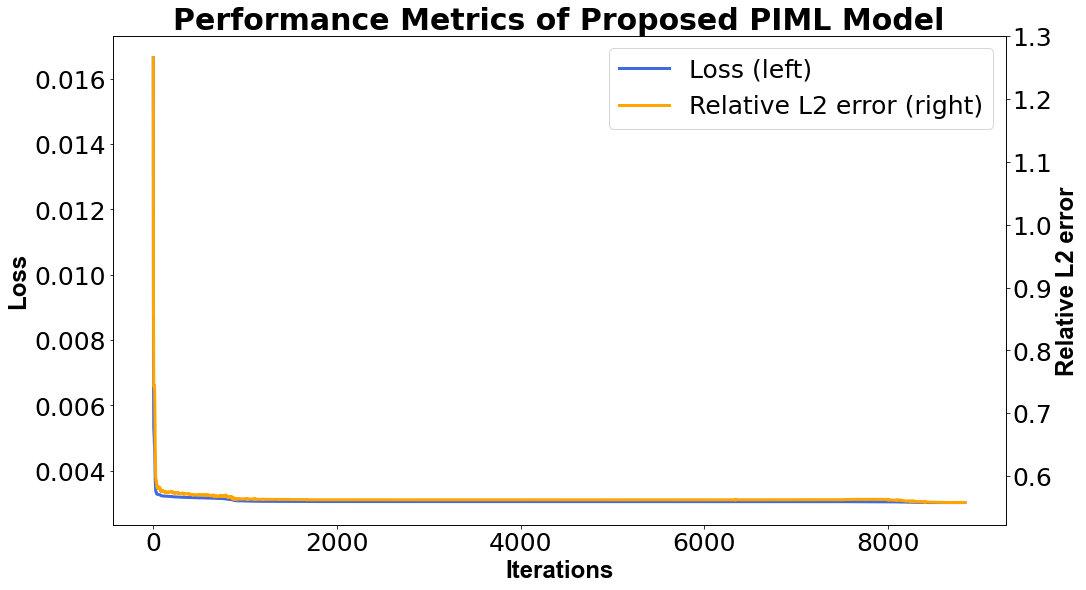

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.021360950140396805
MSE =  0.0028364816902385842
RMSE =  0.0532586301949138
L2 relative error = 0.5053698793849273
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

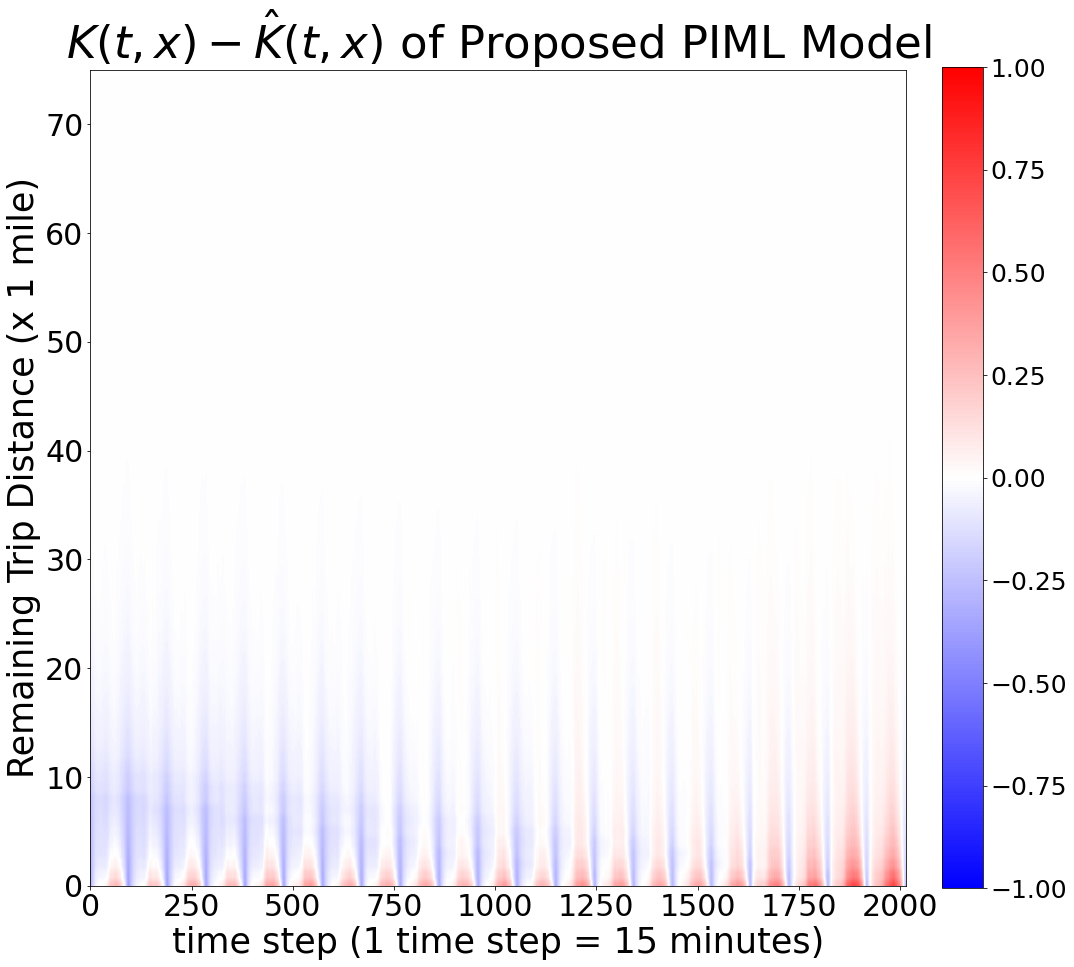

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

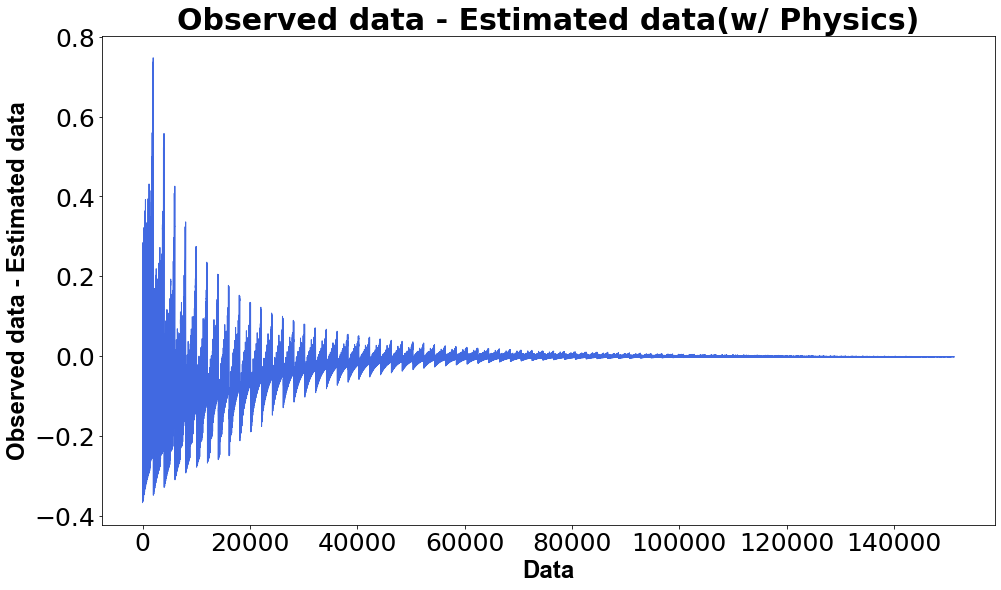

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

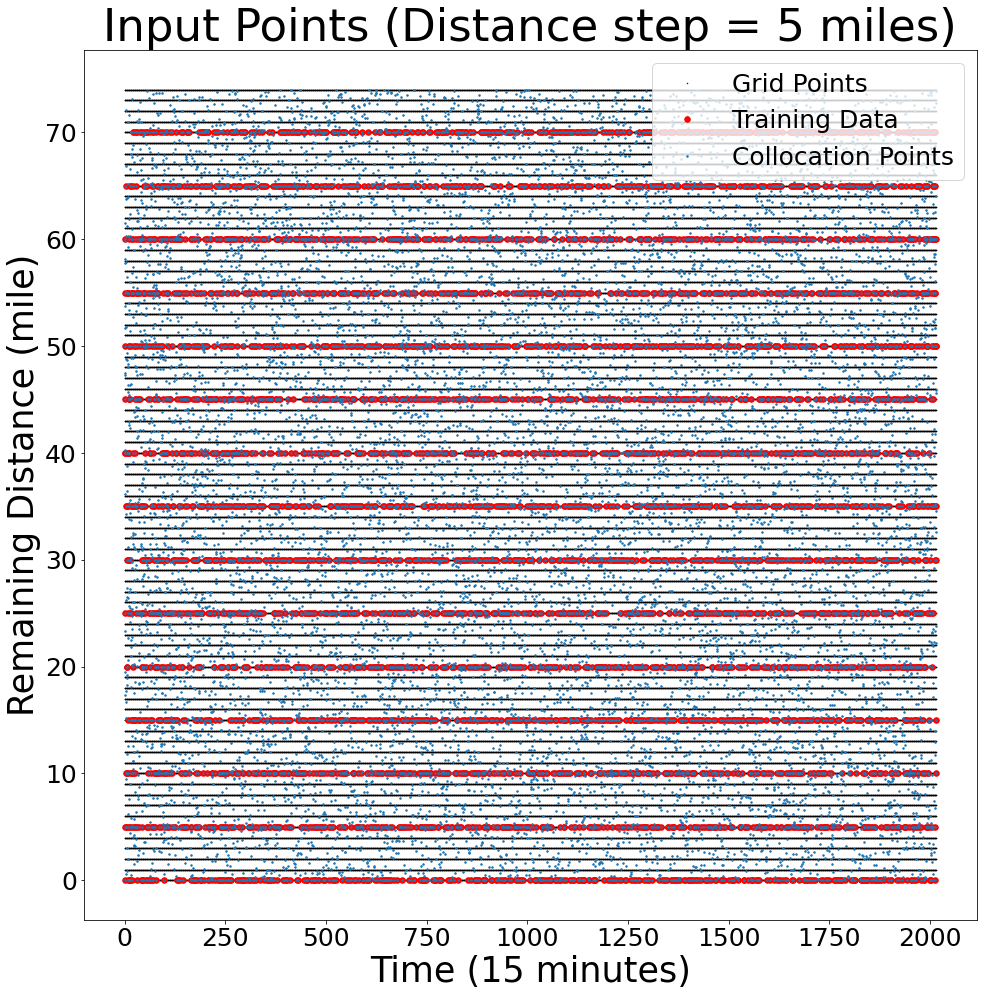

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

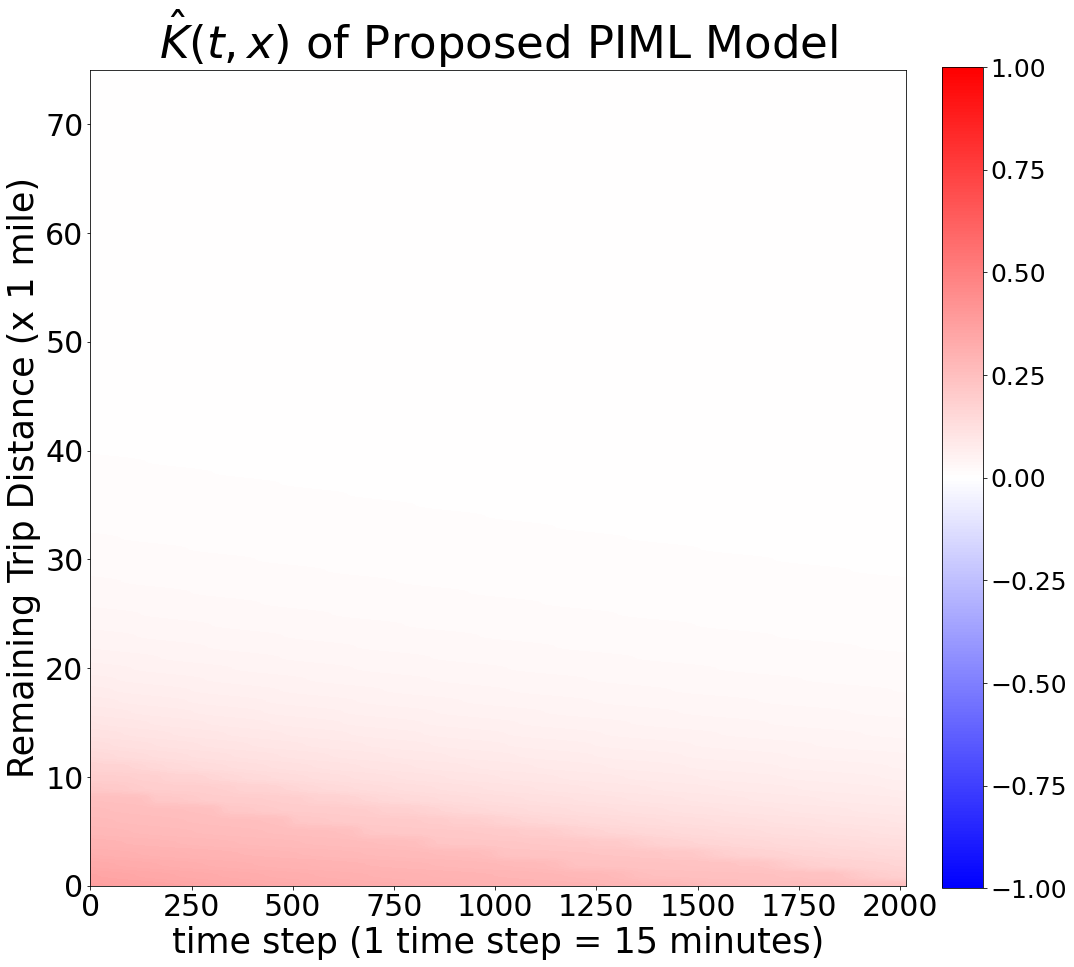

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)